In [3]:
import iris
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import iris.quickplot as qplt
import iris.plot as iplt
import datetime
import shutil
from pathlib import Path
import trackpy
from iris.time import PartialDateTime
import cartopy.crs as ccrs
import xarray as xr
import netCDF4 as nc
import scipy
from scipy import ndimage
from scipy.ndimage import label, generate_binary_structure
import seaborn as sns

#import packages that output memory usage:
#from sys import getsizeof

import tobac #tobac package cloned from https://github.com/tobac-project/tobac.git

import warnings
warnings.filterwarnings('ignore')

import cftime


In [2]:
all_years_cpm = pd.read_hdf('/project/cssp_brazil/mcs_tracking_HG/CPM_HINDCAST_TRACKS/final_tracks_CPM_INTERP/merged/all_years_combined_CCPF/all_years_CCPF_cpm_hindcast.hdf', 'table')
all_years_obs = pd.read_hdf('/project/cssp_brazil/mcs_tracking_HG/OBS_TRACKS/final_tracks_obs/merged/all_years_combined_CCPF/all_years_CCPF.hdf', 'table')
all_years_pd = pd.read_hdf('/project/cssp_brazil/mcs_tracking_HG/CPM_PD_TRACKS/final_tracks_INTERP/merged/all_years_combined_CCPF/all_years_CCPF.hdf', 'table')

In [3]:
time_reference = cftime.Datetime360Day(year=2001, month=1, day=1, hour=0) 
time_reference

cftime.Datetime360Day(2001, 1, 1, 0, 0, 0, 0, has_year_zero=True)

In [4]:
## filter out MCSs before time_reference
all_years_cpm = all_years_cpm[all_years_cpm.datetime.dt.year > 2000]
all_years_pd = all_years_pd[all_years_pd.time >= time_reference]

In [5]:
pd.set_option("display.max_columns", 53)
all_years_pd.sort_values('timestr', ascending=True)

frame  idx      hdim_1      hdim_2   num  threshold_value  feature  \
5          0  155  436.353372  535.307033   732              240        6   
0          0   10  154.105291  336.328864  2434              240        1   
11         1  127  442.353881  535.310852   645              240       12   
6          1   15  155.185866  334.370841  2432              240        7   
16         2   90  445.515227  534.971532   544              240       17   
...      ...  ...         ...         ...   ...              ...      ...   
87526   8614   84  318.251897  358.329265  1430              240    87527   
87545   8615   70  319.138342  355.575886  1549              240    87546   
87552   8615  215  453.824262   80.711020   872              240    87553   
87550   8615  170  421.483733  515.509992  1181              240    87551   
87536   8615    1   24.157687  411.717203  5030              240    87537   

                      time              timestr   latitude  longitude  \
5      2001-01-01 00:30:00  2001-01-01 00:30:00   3.685337 -31.419297   
0      2001-01-01 00:30:00  2001-01-01 00:30:00 -24.539470 -51.317113   
11     2001-01-01 01:30:00  2001-01-01 01:30:00   4.285388 -31.418915   
6      2001-01-01 01:30:00  2001-01-01 01:30:00 -24.431414 -51.512916   
16     2001-01-01 02:30:00  2001-01-01 02:30:00   4.601523 -31.452848   
...                    ...                  ...        ...        ...   
87526  2007-12-29 22:30:00  2007-12-29 22:30:00  -8.124810 -49.117074   
87545  2007-12-29 23:30:00  2007-12-29 23:30:00  -8.036166 -49.392411   
87552  2007-12-29 23:30:00  2007-12-29 23:30:00   5.432426 -76.878896   
87550  2007-12-29 23:30:00  2007-12-29 23:30:00   2.198373 -33.399000   
87536  2007-12-29 23:30:00  2007-12-29 23:30:00 -37.534231 -43.778279   

            cell       time_cell  total_precip  rain_flag  convective_precip  \
5          20016 0 days 00:00:00      0.000000          0           0.000000   
0          20011 0 days 00:00:00   2987.356445        576        2754.433594   
11         20016 0 days 01:00:00   1172.468872        118        1143.849854   
6          20011 0 days 01:00:00   2470.632080        507        2284.967529   
16         20016 0 days 02:00:00   1512.583740        128        1480.636963   
...          ...             ...           ...        ...                ...   
87526  200718185 0 days 09:00:00   1640.028320        229        1581.321533   
87545  200718185 0 days 10:00:00   1475.690430        177        1412.792969   
87552  200718188 0 days 06:00:00    604.956055         87         579.105469   
87550  200718129 1 days 10:00:00   2838.775146        201        2799.202148   
87536  200718170 0 days 19:00:00   6073.257324        850        5756.727539   

       heavy_precip  extreme_precip  heavy_rain_flag  extreme_rain_flag  \
5          0.000000        0.000000                0                  0   
0       1089.112549      167.768356               54                  3   
11       831.459229      278.568542               29                  4   
6        776.963440        0.000000               48                  0   
16      1190.256104        0.000000               51                  0   
...             ...             ...              ...                ...   
87526    984.576416      226.684631               44                  4   
87545    965.475403       54.274784               47                  1   
87552    274.975769        0.000000               13                  0   
87550   2221.052490      482.062256               83                  8   
87536   3267.278809      652.994812              159                 10   

       max_precip  mean_precip_total  mean_precip      tb_min     tb_mean  \
5        0.000000           0.000000     0.000000    0.000000    0.000000   
0       64.729996           1.226840     4.782003  201.556488  221.837967   
11      89.386955           1.803798     9.693643  200.001633  226.603943   
6       39.611160           1.01839

In [6]:
per_mcs_tracks_obs = pd.DataFrame(np.nan, index=np.arange(0,np.unique(all_years_pd.cell.values).shape[0]), columns=['cell'])


In [7]:
per_mcs_tracks_obs['cell'] = np.unique(all_years_pd.cell.values)

In [8]:
per_mcs_tracks_obs

cell
0          20011
1          20016
2          20019
3          20023
4          20032
...          ...
19257  200718170
19258  200718171
19259  200718184
19260  200718185
19261  200718188

[19262 rows x 1 columns]

In [9]:
# # velocity

# import tobac
# import functions

# #first need to run the tobac calculate velocity function before running my own function to create the histogram
# vel_ses_obs = tobac.calculate_velocity(all_years_obs, method_distance=None)

In [10]:
per_mcs_tracks_obs['mean_num'] = 0
per_mcs_tracks_obs['max_num'] = 0
per_mcs_tracks_obs['lifetime'] = 0
per_mcs_tracks_obs['accumulated_precip'] = 0
per_mcs_tracks_obs['max_rain_flag'] = 0
# per_mcs_ses_tracks_obs['accumulated_convective_precip'] = 0
# per_mcs_ses_tracks_obs['accumulated_heavy_precip'] = 0
# per_mcs_ses_tracks_obs['accumulated_extreme_precip'] = 0
# per_mcs_ses_tracks_obs['mean_heavy_rain_flag'] = 0
# per_mcs_ses_tracks_obs['mean_extreme_rain_flag'] = 0
per_mcs_tracks_obs['max_precip'] = 0
# per_mcs_ses_tracks_obs['mean_precip_total'] = 0
# per_mcs_ses_tracks_obs['mean_precip'] = 0
# per_mcs_ses_tracks_obs['tb_min'] = 0
# per_mcs_ses_tracks_obs['tb_mean'] = 0
per_mcs_tracks_obs['mean_size_of_cold_core'] = 0
# per_mcs_ses_tracks_obs['mean_size_tb_200'] = 0
# per_mcs_ses_tracks_obs['mean_size_tb_190'] = 0
# per_mcs_ses_tracks_obs['mean_size_tb_180'] = 0
per_mcs_tracks_obs['max_size_of_cold_core'] = 0
# per_mcs_ses_tracks_obs['max_size_of_tb_200'] = 0
# per_mcs_ses_tracks_obs['max_size_of_tb_190'] = 0
# per_mcs_ses_tracks_obs['max_size_of_tb_180'] = 0
# per_mcs_ses_tracks_obs['max_updraft'] = 0
# per_mcs_ses_tracks_obs['max_downdraft'] = 0
# per_mcs_ses_tracks_obs['mean_updraft'] = 0
# per_mcs_ses_tracks_obs['mean_downdraft'] = 0
# per_mcs_ses_tracks_obs['mean_updraft_area'] = 0
# per_mcs_ses_tracks_obs['mean_downdraft_area'] = 0
# per_mcs_ses_tracks_obs['max_updraft_area'] = 0
# per_mcs_ses_tracks_obs['max_downdraft_area'] = 0
# per_mcs_ses_tracks_obs['max_precip_lat'] = 0
# per_mcs_ses_tracks_obs['max_precip_lon'] = 0
# per_mcs_ses_tracks_obs['min_tb_lat'] = 0
# per_mcs_ses_tracks_obs['min_tb_lon'] = 0
# per_mcs_ses_tracks_obs['max_w_up_lat'] = 0
# per_mcs_ses_tracks_obs['max_w_up_lon'] = 0
# per_mcs_ses_tracks_obs['max_colocated_pixels'] = 0
# per_mcs_ses_tracks_obs['mean_colocated_pixels'] = 0
per_mcs_tracks_obs['initiation_lat'] = 0
per_mcs_tracks_obs['initiation_lon'] = 0
per_mcs_tracks_obs['dissipation_lat'] = 0
per_mcs_tracks_obs['dissipation_lon'] = 0
# per_mcs_tracks_obs['mean_speed'] = 0
per_mcs_tracks_obs['total_distance'] = 0
per_mcs_tracks_obs['year'] = 0
per_mcs_tracks_obs['month'] = 0






In [11]:

for cell in np.unique(all_years_pd.cell.values):
    subset = all_years_pd[all_years_pd.cell == cell]
    per_mcs_tracks_obs['mean_num'][per_mcs_tracks_obs.cell == cell] = int(np.sum(subset.num)/subset.shape[0])
    per_mcs_tracks_obs['max_num'][per_mcs_tracks_obs.cell == cell] = int(subset.num.max())
    # per_mcs_ses_tracks_obs['min_num'][per_mcs_ses_tracks_obs.cell == cell] = int(subset.num.min())
    per_mcs_tracks_obs['lifetime'][per_mcs_tracks_obs.cell == cell] = subset.shape[0]
    per_mcs_tracks_obs['accumulated_precip'][per_mcs_tracks_obs.cell == cell] = float(np.sum(subset.total_precip))
    # per_mcs_ses_tracks_obs['mean_rain_flag'][per_mcs_ses_tracks_obs.cell == cell] = int(np.sum(subset.rain_flag)/subset.shape[0])
    # per_mcs_ses_tracks_obs['max_rain_flag'][per_mcs_ses_tracks_obs.cell == cell] = int(subset.rain_flag.max())
    # per_mcs_ses_tracks_obs['accumulated_convective_precip'][per_mcs_ses_tracks_obs.cell == cell] = float(np.sum(subset.convective_precip))
    # per_mcs_ses_tracks_obs['accumulated_heavy_precip'][per_mcs_ses_tracks_obs.cell == cell] = float(np.sum(subset.heavy_precip))
    # per_mcs_ses_tracks_obs['accumulated_extreme_precip'][per_mcs_ses_tracks_obs.cell == cell] = float(np.sum(subset.extreme_precip))
    # per_mcs_ses_tracks_obs['mean_heavy_rain_flag'][per_mcs_ses_tracks_obs.cell == cell] = int(np.sum(subset.heavy_rain_flag)/subset.shape[0])
    # per_mcs_ses_tracks_obs['mean_extreme_rain_flag'][per_mcs_ses_tracks_obs.cell == cell] = int(np.sum(subset.extreme_rain_flag)/subset.shape[0])
    per_mcs_tracks_obs['max_precip'][per_mcs_tracks_obs.cell == cell] = float(subset.max_precip.max())
    # per_mcs_ses_tracks_obs['mean_precip_total'][per_mcs_ses_tracks_obs.cell == cell] = float(np.sum(subset.mean_precip_total)/subset.shape[0])
    # per_mcs_ses_tracks_obs['mean_precip'][per_mcs_ses_tracks_obs.cell == cell] = float(np.sum(subset.mean_precip)/subset.shape[0])
    # per_mcs_ses_tracks_obs['tb_min'][per_mcs_ses_tracks_obs.cell == cell] = float(subset.tb_min.min())
    # per_mcs_ses_tracks_obs['tb_mean'][per_mcs_ses_tracks_obs.cell == cell] = float(np.sum(subset.tb_mean)/subset.shape[0])
    per_mcs_tracks_obs['mean_size_of_cold_core'][per_mcs_tracks_obs.cell == cell] = int(np.sum(subset.tb_210)/subset.shape[0])
    # per_mcs_ses_tracks_obs['mean_size_tb_200'][per_mcs_ses_tracks_obs.cell == cell] = int(np.sum(subset.tb_200)/subset.shape[0])
    # per_mcs_ses_tracks_obs['mean_size_tb_190'][per_mcs_ses_tracks_obs.cell == cell] = int(np.sum(subset.tb_190)/subset.shape[0])
    # per_mcs_ses_tracks_obs['mean_size_tb_180'][per_mcs_ses_tracks_obs.cell == cell] = int(np.sum(subset.tb_180)/subset.shape[0])
    per_mcs_tracks_obs['max_size_of_cold_core'][per_mcs_tracks_obs.cell == cell] = int(subset.tb_210.max())
    # per_mcs_ses_tracks_obs['max_size_of_tb_200'][per_mcs_ses_tracks_obs.cell == cell] = int(subset.tb_200.max())
    # per_mcs_ses_tracks_obs['max_size_of_tb_190'][per_mcs_ses_tracks_obs.cell == cell] = int(subset.tb_190.max())
    # per_mcs_ses_tracks_obs['max_size_of_tb_180'][per_mcs_ses_tracks_obs.cell == cell] = int(subset.tb_180.max())
    # per_mcs_ses_tracks_obs['max_updraft'][per_mcs_ses_tracks_obs.cell == cell] = float(subset.w_max.max())
    # per_mcs_ses_tracks_obs['max_downdraft'][per_mcs_ses_tracks_obs.cell == cell] = float(subset.w_min.min())
    # per_mcs_ses_tracks_obs['mean_updraft'][per_mcs_ses_tracks_obs.cell == cell] = float(np.sum(subset.w_mean_up)/subset.w_mean_up.dropna().shape[0])
    # per_mcs_ses_tracks_obs['mean_downdraft'][per_mcs_ses_tracks_obs.cell == cell] = float(np.sum(subset.w_mean_down)/subset.w_mean_down.dropna().shape[0])
    # per_mcs_ses_tracks_obs['mean_updraft_area'][per_mcs_ses_tracks_obs.cell == cell] = float(np.sum(subset.w_up_area)/subset.w_up_area.dropna().shape[0])
    # per_mcs_ses_tracks_obs['mean_downdraft_area'][per_mcs_ses_tracks_obs.cell == cell] = float(np.sum(subset.w_down_area)/subset.w_down_area.dropna().shape[0])
    # per_mcs_ses_tracks_obs['max_updraft_area'][per_mcs_ses_tracks_obs.cell == cell] = float(subset.w_up_area.max())
    # per_mcs_ses_tracks_obs['max_downdraft_area'][per_mcs_ses_tracks_obs.cell == cell] = float(subset.w_down_area.max())
    # per_mcs_ses_tracks_obs['max_precip_lat'][per_mcs_ses_tracks_obs.cell == cell] = float(subset.max_precip_lat[subset.max_precip == subset.max_precip.max()].iloc[0])
    # per_mcs_ses_tracks_obs['max_precip_lon'][per_mcs_ses_tracks_obs.cell == cell] = float(subset.max_precip_lon[subset.max_precip == subset.max_precip.max()].iloc[0])
    # per_mcs_ses_tracks_obs['min_tb_lat'][per_mcs_ses_tracks_obs.cell == cell] = float(subset.min_tb_lat[subset.tb_min == subset.tb_min.min()].iloc[0])
    # per_mcs_ses_tracks_obs['min_tb_lon'][per_mcs_ses_tracks_obs.cell == cell] = float(subset.min_tb_lon[subset.tb_min == subset.tb_min.min()].iloc[0])
    # per_mcs_ses_tracks_obs['max_colocated_pixels'][per_mcs_ses_tracks_obs.cell == cell] = float(subset.colocated_pixels.max())
    # per_mcs_ses_tracks_obs['mean_colocated_pixels'][per_mcs_ses_tracks_obs.cell == cell] = int(np.sum(subset.colocated_pixels)/subset.shape[0])
    per_mcs_tracks_obs['initiation_lat'][per_mcs_tracks_obs.cell == cell] = float(subset.head(1).latitude)
    per_mcs_tracks_obs['initiation_lon'][per_mcs_tracks_obs.cell == cell] = float(subset.head(1).longitude)
    per_mcs_tracks_obs['dissipation_lat'][per_mcs_tracks_obs.cell == cell] = float(subset.tail(1).latitude)
    per_mcs_tracks_obs['dissipation_lon'][per_mcs_tracks_obs.cell == cell] = float(subset.tail(1).longitude)
    # per_mcs_tracks_obs['mean_speed'][per_mcs_tracks_obs.cell == cell] = float(subset.v.mean())
    per_mcs_tracks_obs['month'][per_mcs_tracks_obs.cell == cell] = int(subset.head(1).time.to_string(index=False).split('-')[1])
    per_mcs_tracks_obs['year'][per_mcs_tracks_obs.cell == cell] = int(subset.head(1).time.to_string(index=False).split('-')[0])


    # if subset.w_max.max() > 0:
    #     per_mcs_ses_tracks_obs['max_w_up_lat'][per_mcs_ses_tracks_obs.cell == cell] = float(subset.max_w_up_lat[subset.w_max == subset.w_max.max()].head(1))
    #     per_mcs_ses_tracks_obs['max_w_up_lon'][per_mcs_ses_tracks_obs.cell == cell] = float(subset.max_w_up_lon[subset.w_max == subset.w_max.max()].head(1))
    # else:
    #     per_mcs_ses_tracks_obs['max_w_up_lat'][per_mcs_ses_tracks_obs.cell == cell] = float('NaN')
    #     per_mcs_ses_tracks_obs['max_w_up_lon'][per_mcs_ses_tracks_obs.cell == cell] = float('NaN')


In [12]:
for cell in np.unique(all_years_pd.cell.values):
    subset = all_years_pd[all_years_pd.cell == cell]
    subset['distance']=0
    for x in np.arange(subset.shape[0]):
        if x != np.arange(subset.shape[0])[-1]:
            dist = tobac.calculate_distance(subset.iloc[x], subset.iloc[x+1], method_distance=None)
            subset['distance'].iloc[x] = dist
            x = x+1
        elif x == np.arange(subset.shape[0])[-1]:
            subset['distance'].iloc[x] = np.nan

    total_dist = np.sum(subset['distance'])/1000 ## TO CONVERT FROM M TO KM 
    per_mcs_tracks_obs['total_distance'][per_mcs_tracks_obs.cell == cell] = total_dist

In [13]:
per_mcs_tracks_obs

cell  mean_num  max_num  lifetime  accumulated_precip  \
0          20011      1602     2434        11         9157.758747   
1          20016       775      943        13        20459.077576   
2          20019      2469     3344         8        14597.701050   
3          20023      7903    13013        19       154169.174316   
4          20032      1692     2099         9        16780.750000   
...          ...       ...      ...       ...                 ...   
19257  200718170      3536     5030        20        68636.957764   
19258  200718171       947     2805        16        44877.952026   
19259  200718184       511      625         8         5719.862850   
19260  200718185      1249     1549        11        11348.629272   
19261  200718188       646      872         7         7477.413452   

       max_rain_flag  max_precip  mean_size_of_cold_core  \
0                  0   64.729996                      60   
1                  0   93.549286                     111   
2                  0   92.295433                     698   
3                  0   98.462570                    1593   
4                  0   76.283661                      90   
...              ...         ...                     ...   
19257              0   99.913612                      13   
19258              0   84.755829                      18   
19259              0   70.226181                      65   
19260              0   87.169563                     158   
19261              0   56.449154                      73   

       max_size_of_cold_core  initiation_lat  initiation_lon  dissipation_lat  \
0                        280      -24.539470      -51.317113       -22.896799   
1                        231        3.685337      -31.419297         4.171966   
2                        836       -2.752440      -68.647413        -2.533921   
3                       3678       -8.696914      -70.823636        -9.867238   
4                        190      -29.682555      -50.326573       -30.459324   
...                      ...             ...             ...              ...   
19257                    108      -33.641077      -53.967189       -37.534231   
19258                    102      -27.185789      -64.292746       -31.285775   
19259                    149        2.749983      -48.956495         3.525932   
19260                    326       -9.759081      -48.474739        -8.036166   
19261                    125        5.337439      -78.526661         5.432426   

       dissipation_lon  total_distance  year  month  
0           -53.018341      330.794779  2001      1  
1           -31.245233      201.909312  2001      1  
2           -69.324011      291.762359  2001      1  
3           -75.721068      975.237222  2002      1  
4           -47.406963      427.489255  2003      1  
...                ...             ...   ...    ...  
19257       -43.778279     1094.098886  2007     12  
19258       -51.655055     1376.927373  2007     12  
19259       -49.272331      140.543401  2007     12  
19260       -49.392411      321.846175  2007     12  
19261       -76.878896      211.486182  2007     12  

[19262 rows x 16 columns]

In [14]:
per_mcs_tracks_obs.to_hdf('/project/cssp_brazil/mcs_tracking_HG/CPM_PD_TRACKS/final_tracks_INTERP/regional_box_tracks/per_mcs_ALL_tracks_pd.hdf', 'table')


## Testing plotting using plt.hexbin ##

In [2]:
## Load in all dataframes ##
obs = pd.read_hdf('/project/cssp_brazil/mcs_tracking_HG/OBS_TRACKS/final_tracks_obs/regional_box_tracks/per_mcs_ALL_tracks_obs.hdf', 'table')
cpm_h = pd.read_hdf('/project/cssp_brazil/mcs_tracking_HG/CPM_HINDCAST_TRACKS/final_tracks_CPM_INTERP/regional_box_tracks/per_mcs_ALL_tracks_h.hdf', 'table')
cpm_pd = pd.read_hdf('/project/cssp_brazil/mcs_tracking_HG/CPM_PD_TRACKS/final_tracks_INTERP/regional_box_tracks/per_mcs_ALL_tracks_pd.hdf', 'table')

In [3]:
obs[obs.max_num >= (np.percentile(obs.max_num, 95))]

cell  mean_num  max_num  lifetime  accumulated_precip  \
24        200219      5141     9005        11        74380.745605   
111      2001166      4199     8129        15       143306.306641   
148      2001410      2799     9096        11        58209.531006   
153      2001475      3553     8040        27       249424.878479   
164      2001570      5607    11067         7       158509.910156   
...          ...       ...      ...       ...                 ...   
16422  200717503      8848    13503         8        77766.154297   
16466  200717896      1836     7992        19        63071.860138   
16495  200718121      3596     8513        15       116337.481445   
16508  200718248      3812     7966        14        55634.661407   
16529  200718416      4805     9203        11        94141.769043   

       max_rain_flag  max_precip  mean_size_of_cold_core  \
24                 0   42.063297                     120   
111                0   69.868164                     987   
148                0   44.352928                     560   
153                0  106.439995                     584   
164                0   60.205799                    2659   
...              ...         ...                     ...   
16422              0   43.377289                     926   
16466              0   48.247337                     178   
16495              0   44.280087                     178   
16508              0   45.377419                     536   
16529              0   68.147949                     842   

       max_size_of_cold_core  initiation_lat  initiation_lon  dissipation_lat  \
24                       336      -11.912036      -59.362213       -12.500949   
111                     1242      -16.212045      -66.753362       -14.758869   
148                     1965      -13.259648      -48.053287       -18.424660   
153                     2558      -33.141014      -64.621762       -34.467944   
164                     3829      -26.027837      -62.514889       -22.375249   
...                      ...             ...             ...              ...   
16422                   2251      -15.388192      -64.421604       -14.040452   
16466                   1076       -9.071249      -51.162898       -11.108390   
16495                    495      -28.591202      -63.280114       -27.267695   
16508                   1545       -4.815811      -52.671740        -2.161666   
16529                   1969      -21.250973      -58.309713       -20.005352   

       dissipation_lon  total_distance  year  month  
24          -61.077271      733.049871  2002      1  
111         -67.219782      686.087934  2001      1  
148         -52.137621      791.778522  2001      1  
153         -60.290182     1143.236182  2001      1  
164         -63.412514      695.522969  2001      1  
...                ...             ...   ...    ...  
16422       -65.042119      405.440154  2007     12  
16466       -46.076011     1159.672563  2007     12  
16495       -56.561008      845.152791  2007     12  
16508       -48.537062     1039.150420  2007     12  
16529       -59.377558      661.089997  2007     12  

[827 rows x 16 columns]

Text(0.5, 0.98, '95th percentile max cloud shield area')

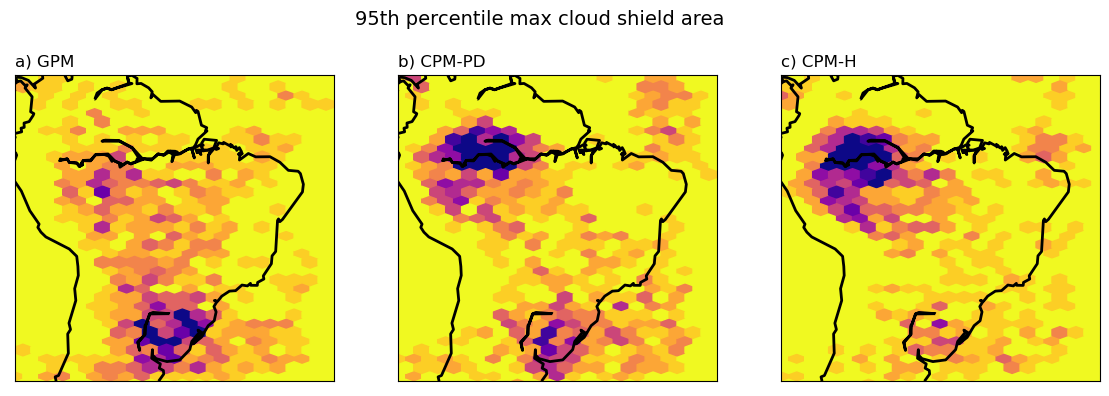

In [4]:
## largest by max area

import mpl_toolkits
from mpl_toolkits.basemap import Basemap

x_o = obs.initiation_lon[obs.max_num >= (np.percentile(obs.max_num, 95))]
y_o = obs.initiation_lat[obs.max_num >= (np.percentile(obs.max_num, 95))]

x_f = cpm_h.initiation_lon[cpm_h.max_num >= (np.percentile(cpm_h.max_num, 95))]
y_f = cpm_h.initiation_lat[cpm_h.max_num >= (np.percentile(cpm_h.max_num, 95))]

x_pd = cpm_pd.initiation_lon[cpm_pd.max_num >= (np.percentile(cpm_pd.max_num, 95))]
y_pd = cpm_pd.initiation_lat[cpm_pd.max_num >= (np.percentile(cpm_pd.max_num, 95))]

fig = plt.figure(figsize=(14, 4.5))

ax1 = plt.subplot(1,3,1)
m = Basemap(llcrnrlon=-80, llcrnrlat=-38,urcrnrlon=-30, urcrnrlat=10) # create Basemap object
m.drawcoastlines(linewidth=2) # draw coastlines
hx_o = m.hexbin(x_o, y_o, gridsize=(20,20), cmap='plasma_r',vmin=0,vmax=10, extent=(-80, -30, -40, 15))
plt.title('a) GPM', loc='left')

ax2 = plt.subplot(1,3,2)
m = Basemap(llcrnrlon=-80, llcrnrlat=-38,urcrnrlon=-30, urcrnrlat=10) # create Basemap object
m.drawcoastlines(linewidth=2) # draw coastlines
hx_pd = m.hexbin(x_pd, y_pd, gridsize=(20,20), cmap='plasma_r',vmin=0,vmax=10, extent=(-80, -30, -40, 15))
plt.title('b) CPM-PD', loc='left')

ax3 = plt.subplot(1,3,3)
m = Basemap(llcrnrlon=-80, llcrnrlat=-38,urcrnrlon=-30, urcrnrlat=10) # create Basemap object
m.drawcoastlines(linewidth=2) # draw coastlines
hx_pd = m.hexbin(x_f, y_f, gridsize=(20,20), cmap='plasma_r',vmin=0,vmax=10, extent=(-80, -30, -40, 15))
plt.title('c) CPM-H', loc='left')

plt.suptitle('95th percentile max cloud shield area', fontsize=14)


Text(0.5, 0.98, '95th percentile mean cloud shield area')

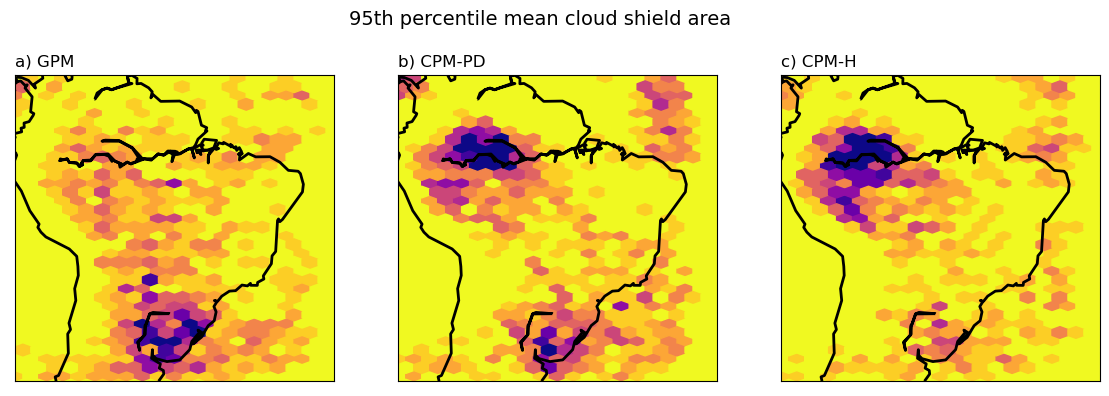

In [5]:
## largest by max area

import mpl_toolkits
from mpl_toolkits.basemap import Basemap

x_o = obs.initiation_lon[obs.mean_num >= (np.percentile(obs.mean_num, 95))]
y_o = obs.initiation_lat[obs.mean_num >= (np.percentile(obs.mean_num, 95))]

x_f = cpm_h.initiation_lon[cpm_h.mean_num >= (np.percentile(cpm_h.mean_num, 95))]
y_f = cpm_h.initiation_lat[cpm_h.mean_num >= (np.percentile(cpm_h.mean_num, 95))]

x_pd = cpm_pd.initiation_lon[cpm_pd.mean_num >= (np.percentile(cpm_pd.mean_num, 95))]
y_pd = cpm_pd.initiation_lat[cpm_pd.mean_num >= (np.percentile(cpm_pd.mean_num, 95))]

fig = plt.figure(figsize=(14, 4.5))

ax1 = plt.subplot(1,3,1)
m = Basemap(llcrnrlon=-80, llcrnrlat=-38,urcrnrlon=-30, urcrnrlat=10) # create Basemap object
m.drawcoastlines(linewidth=2) # draw coastlines
hx_o = m.hexbin(x_o, y_o, gridsize=(20,20), cmap='plasma_r',vmin=0,vmax=10, extent=(-80, -30, -40, 15))
plt.title('a) GPM', loc='left')

ax2 = plt.subplot(1,3,2)
m = Basemap(llcrnrlon=-80, llcrnrlat=-38,urcrnrlon=-30, urcrnrlat=10) # create Basemap object
m.drawcoastlines(linewidth=2) # draw coastlines
hx_pd = m.hexbin(x_pd, y_pd, gridsize=(20,20), cmap='plasma_r',vmin=0,vmax=10, extent=(-80, -30, -40, 15))
plt.title('b) CPM-PD', loc='left')

ax3 = plt.subplot(1,3,3)
m = Basemap(llcrnrlon=-80, llcrnrlat=-38,urcrnrlon=-30, urcrnrlat=10) # create Basemap object
m.drawcoastlines(linewidth=2) # draw coastlines
hx_pd = m.hexbin(x_f, y_f, gridsize=(20,20), cmap='plasma_r',vmin=0,vmax=10, extent=(-80, -30, -40, 15))
plt.title('c) CPM-H', loc='left')

plt.suptitle('95th percentile mean cloud shield area', fontsize=14)


Text(0.5, 0.98, '95th percentile MCS duration')

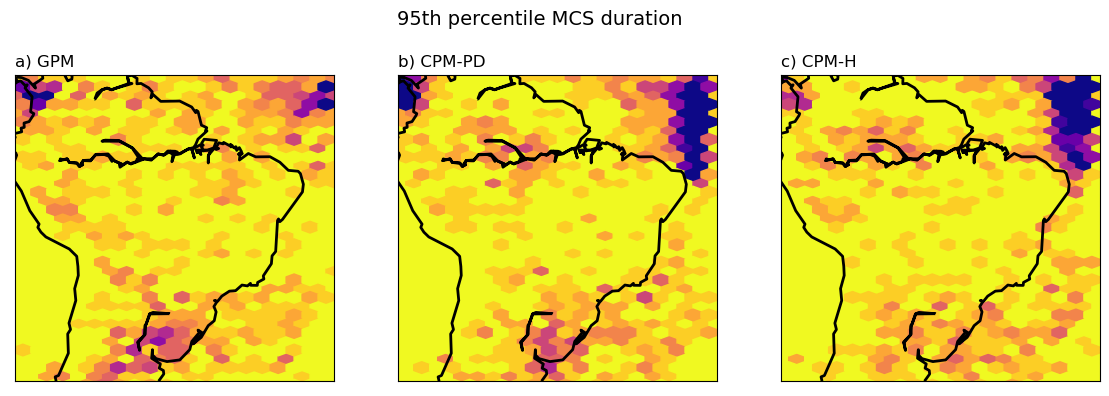

In [6]:
## largest by max area

import mpl_toolkits
from mpl_toolkits.basemap import Basemap

x_o = obs.initiation_lon[obs.lifetime >= (np.percentile(obs.lifetime, 95))]
y_o = obs.initiation_lat[obs.lifetime >= (np.percentile(obs.lifetime, 95))]

x_f = cpm_h.initiation_lon[cpm_h.lifetime >= (np.percentile(cpm_h.lifetime, 95))]
y_f = cpm_h.initiation_lat[cpm_h.lifetime >= (np.percentile(cpm_h.lifetime, 95))]

x_pd = cpm_pd.initiation_lon[cpm_pd.lifetime >= (np.percentile(cpm_pd.lifetime, 95))]
y_pd = cpm_pd.initiation_lat[cpm_pd.lifetime >= (np.percentile(cpm_pd.lifetime, 95))]

fig = plt.figure(figsize=(14, 4.5))

ax1 = plt.subplot(1,3,1)
m = Basemap(llcrnrlon=-80, llcrnrlat=-38,urcrnrlon=-30, urcrnrlat=10) # create Basemap object
m.drawcoastlines(linewidth=2) # draw coastlines
hx_o = m.hexbin(x_o, y_o, gridsize=(20,20), cmap='plasma_r',vmin=0,vmax=10, extent=(-80, -30, -40, 15))
plt.title('a) GPM', loc='left')

ax2 = plt.subplot(1,3,2)
m = Basemap(llcrnrlon=-80, llcrnrlat=-38,urcrnrlon=-30, urcrnrlat=10) # create Basemap object
m.drawcoastlines(linewidth=2) # draw coastlines
hx_pd = m.hexbin(x_pd, y_pd, gridsize=(20,20), cmap='plasma_r',vmin=0,vmax=10, extent=(-80, -30, -40, 15))
plt.title('b) CPM-PD', loc='left')

ax3 = plt.subplot(1,3,3)
m = Basemap(llcrnrlon=-80, llcrnrlat=-38,urcrnrlon=-30, urcrnrlat=10) # create Basemap object
m.drawcoastlines(linewidth=2) # draw coastlines
hx_pd = m.hexbin(x_f, y_f, gridsize=(20,20), cmap='plasma_r',vmin=0,vmax=10, extent=(-80, -30, -40, 15))
plt.title('c) CPM-H', loc='left')

plt.suptitle('95th percentile MCS duration', fontsize=14)


Text(0.5, 0.98, '95th percentile MCS total precip.')

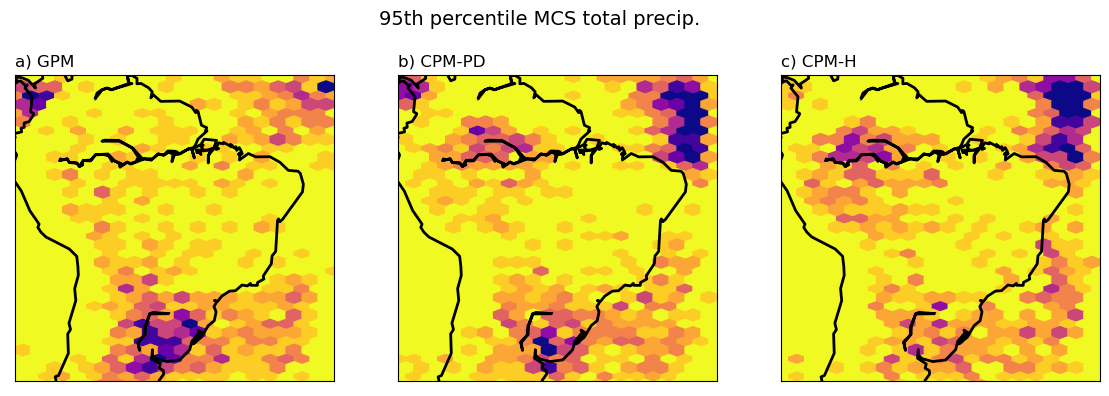

In [7]:
## largest by max area

import mpl_toolkits
from mpl_toolkits.basemap import Basemap

x_o = obs.initiation_lon[obs.accumulated_precip >= (np.percentile(obs.accumulated_precip, 95))]
y_o = obs.initiation_lat[obs.accumulated_precip >= (np.percentile(obs.accumulated_precip, 95))]

x_f = cpm_h.initiation_lon[cpm_h.accumulated_precip >= (np.percentile(cpm_h.accumulated_precip, 95))]
y_f = cpm_h.initiation_lat[cpm_h.accumulated_precip >= (np.percentile(cpm_h.accumulated_precip, 95))]

x_pd = cpm_pd.initiation_lon[cpm_pd.accumulated_precip >= (np.percentile(cpm_pd.accumulated_precip, 95))]
y_pd = cpm_pd.initiation_lat[cpm_pd.accumulated_precip >= (np.percentile(cpm_pd.accumulated_precip, 95))]

fig = plt.figure(figsize=(14, 4.5))

ax1 = plt.subplot(1,3,1)
m = Basemap(llcrnrlon=-80, llcrnrlat=-38,urcrnrlon=-30, urcrnrlat=10) # create Basemap object
m.drawcoastlines(linewidth=2) # draw coastlines
hx_o = m.hexbin(x_o, y_o, gridsize=(20,20), cmap='plasma_r',vmin=0,vmax=10, extent=(-80, -30, -40, 15))
plt.title('a) GPM', loc='left')

ax2 = plt.subplot(1,3,2)
m = Basemap(llcrnrlon=-80, llcrnrlat=-38,urcrnrlon=-30, urcrnrlat=10) # create Basemap object
m.drawcoastlines(linewidth=2) # draw coastlines
hx_pd = m.hexbin(x_pd, y_pd, gridsize=(20,20), cmap='plasma_r',vmin=0,vmax=10, extent=(-80, -30, -40, 15))
plt.title('b) CPM-PD', loc='left')

ax3 = plt.subplot(1,3,3)
m = Basemap(llcrnrlon=-80, llcrnrlat=-38,urcrnrlon=-30, urcrnrlat=10) # create Basemap object
m.drawcoastlines(linewidth=2) # draw coastlines
hx_pd = m.hexbin(x_f, y_f, gridsize=(20,20), cmap='plasma_r',vmin=0,vmax=10, extent=(-80, -30, -40, 15))
plt.title('c) CPM-H', loc='left')

plt.suptitle('95th percentile MCS total precip.', fontsize=14)


Text(0.5, 0.98, '95th percentile MCS max precip. rate')

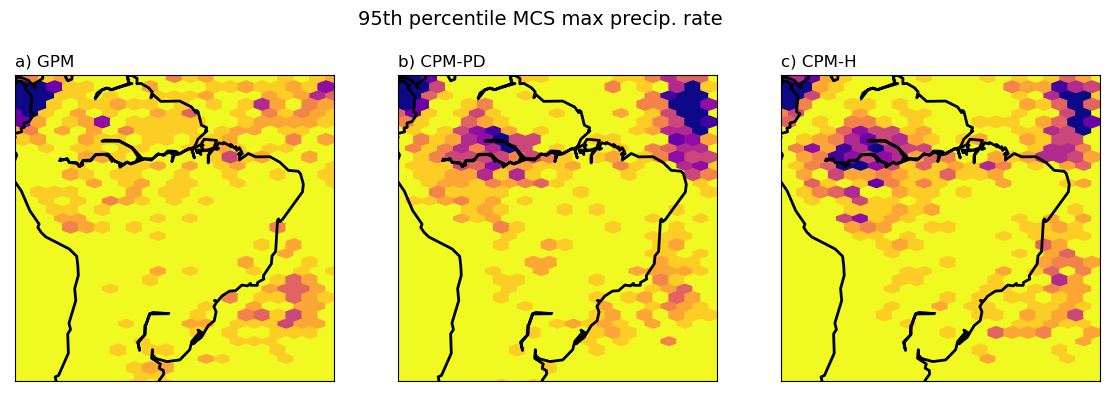

In [8]:
## largest by max area

import mpl_toolkits
from mpl_toolkits.basemap import Basemap

x_o = obs.initiation_lon[obs.max_precip >= (np.percentile(obs.max_precip, 95))]
y_o = obs.initiation_lat[obs.max_precip >= (np.percentile(obs.max_precip, 95))]

x_f = cpm_h.initiation_lon[cpm_h.max_precip >= (np.percentile(cpm_h.max_precip, 95))]
y_f = cpm_h.initiation_lat[cpm_h.max_precip >= (np.percentile(cpm_h.max_precip, 95))]

x_pd = cpm_pd.initiation_lon[cpm_pd.max_precip >= (np.percentile(cpm_pd.max_precip, 95))]
y_pd = cpm_pd.initiation_lat[cpm_pd.max_precip >= (np.percentile(cpm_pd.max_precip, 95))]

fig = plt.figure(figsize=(14, 4.5))

ax1 = plt.subplot(1,3,1)
m = Basemap(llcrnrlon=-80, llcrnrlat=-38,urcrnrlon=-30, urcrnrlat=10) # create Basemap object
m.drawcoastlines(linewidth=2) # draw coastlines
hx_o = m.hexbin(x_o, y_o, gridsize=(20,20), cmap='plasma_r',vmin=0,vmax=10, extent=(-80, -30, -40, 15))
plt.title('a) GPM', loc='left')

ax2 = plt.subplot(1,3,2)
m = Basemap(llcrnrlon=-80, llcrnrlat=-38,urcrnrlon=-30, urcrnrlat=10) # create Basemap object
m.drawcoastlines(linewidth=2) # draw coastlines
hx_pd = m.hexbin(x_pd, y_pd, gridsize=(20,20), cmap='plasma_r',vmin=0,vmax=10, extent=(-80, -30, -40, 15))
plt.title('b) CPM-PD', loc='left')

ax3 = plt.subplot(1,3,3)
m = Basemap(llcrnrlon=-80, llcrnrlat=-38,urcrnrlon=-30, urcrnrlat=10) # create Basemap object
m.drawcoastlines(linewidth=2) # draw coastlines
hx_pd = m.hexbin(x_f, y_f, gridsize=(20,20), cmap='plasma_r',vmin=0,vmax=10, extent=(-80, -30, -40, 15))
plt.title('c) CPM-H', loc='left')

plt.suptitle('95th percentile MCS max precip. rate', fontsize=14)


Text(0.5, 0.98, '95th percentile MCS cold core size')

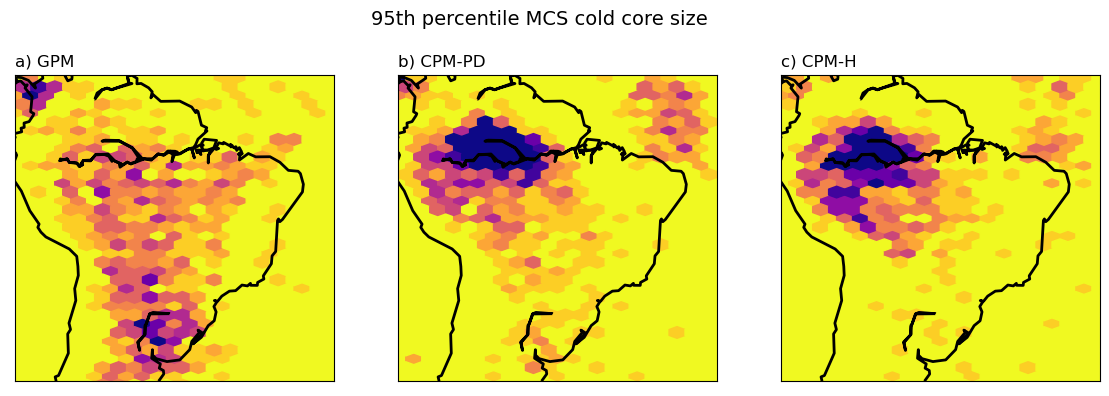

In [9]:
## largest by max area

import mpl_toolkits
from mpl_toolkits.basemap import Basemap

x_o = obs.initiation_lon[obs.max_size_of_cold_core >= (np.percentile(obs.max_size_of_cold_core, 95))]
y_o = obs.initiation_lat[obs.max_size_of_cold_core >= (np.percentile(obs.max_size_of_cold_core, 95))]

x_f = cpm_h.initiation_lon[cpm_h.max_size_of_cold_core >= (np.percentile(cpm_h.max_size_of_cold_core, 95))]
y_f = cpm_h.initiation_lat[cpm_h.max_size_of_cold_core >= (np.percentile(cpm_h.max_size_of_cold_core, 95))]

x_pd = cpm_pd.initiation_lon[cpm_pd.max_size_of_cold_core >= (np.percentile(cpm_pd.max_size_of_cold_core, 95))]
y_pd = cpm_pd.initiation_lat[cpm_pd.max_size_of_cold_core >= (np.percentile(cpm_pd.max_size_of_cold_core, 95))]

fig = plt.figure(figsize=(14, 4.5))

ax1 = plt.subplot(1,3,1)
m = Basemap(llcrnrlon=-80, llcrnrlat=-38,urcrnrlon=-30, urcrnrlat=10) # create Basemap object
m.drawcoastlines(linewidth=2) # draw coastlines
hx_o = m.hexbin(x_o, y_o, gridsize=(20,20), cmap='plasma_r',vmin=0,vmax=10, extent=(-80, -30, -40, 15))
plt.title('a) GPM', loc='left')

ax2 = plt.subplot(1,3,2)
m = Basemap(llcrnrlon=-80, llcrnrlat=-38,urcrnrlon=-30, urcrnrlat=10) # create Basemap object
m.drawcoastlines(linewidth=2) # draw coastlines
hx_pd = m.hexbin(x_pd, y_pd, gridsize=(20,20), cmap='plasma_r',vmin=0,vmax=10, extent=(-80, -30, -40, 15))
plt.title('b) CPM-PD', loc='left')

ax3 = plt.subplot(1,3,3)
m = Basemap(llcrnrlon=-80, llcrnrlat=-38,urcrnrlon=-30, urcrnrlat=10) # create Basemap object
m.drawcoastlines(linewidth=2) # draw coastlines
hx_pd = m.hexbin(x_f, y_f, gridsize=(20,20), cmap='plasma_r',vmin=0,vmax=10, extent=(-80, -30, -40, 15))
plt.title('c) CPM-H', loc='left')

plt.suptitle('95th percentile MCS cold core size', fontsize=14)


Text(0.5, 0.98, '95th percentile MCS track length')

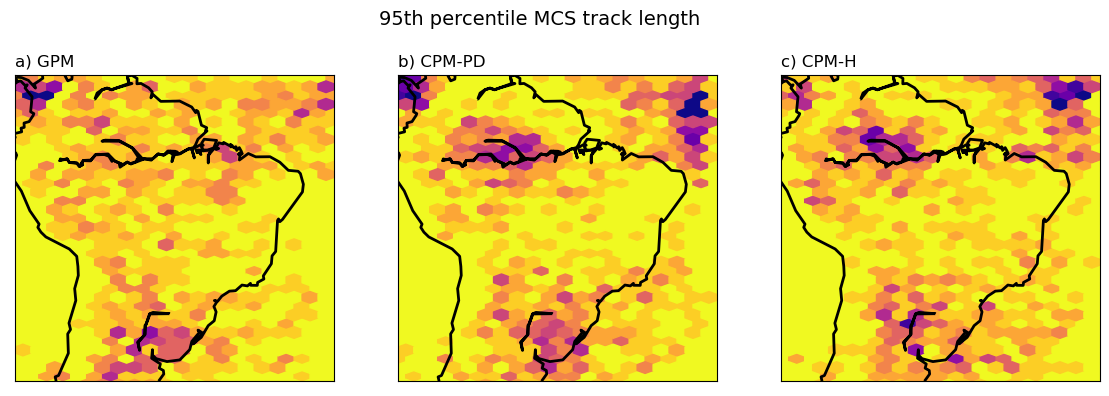

In [10]:
## largest by max area

import mpl_toolkits
from mpl_toolkits.basemap import Basemap

x_o = obs.initiation_lon[obs.total_distance >= (np.percentile(obs.total_distance, 95))]
y_o = obs.initiation_lat[obs.total_distance >= (np.percentile(obs.total_distance, 95))]

x_f = cpm_h.initiation_lon[cpm_h.total_distance >= (np.percentile(cpm_h.total_distance, 95))]
y_f = cpm_h.initiation_lat[cpm_h.total_distance >= (np.percentile(cpm_h.total_distance, 95))]

x_pd = cpm_pd.initiation_lon[cpm_pd.total_distance >= (np.percentile(cpm_pd.total_distance, 95))]
y_pd = cpm_pd.initiation_lat[cpm_pd.total_distance >= (np.percentile(cpm_pd.total_distance, 95))]

fig = plt.figure(figsize=(14, 4.5))

ax1 = plt.subplot(1,3,1)
m = Basemap(llcrnrlon=-80, llcrnrlat=-38,urcrnrlon=-30, urcrnrlat=10) # create Basemap object
m.drawcoastlines(linewidth=2) # draw coastlines
hx_o = m.hexbin(x_o, y_o, gridsize=(20,20), cmap='plasma_r',vmin=0,vmax=10, extent=(-80, -30, -40, 15))
plt.title('a) GPM', loc='left')

ax2 = plt.subplot(1,3,2)
m = Basemap(llcrnrlon=-80, llcrnrlat=-38,urcrnrlon=-30, urcrnrlat=10) # create Basemap object
m.drawcoastlines(linewidth=2) # draw coastlines
hx_pd = m.hexbin(x_pd, y_pd, gridsize=(20,20), cmap='plasma_r',vmin=0,vmax=10, extent=(-80, -30, -40, 15))
plt.title('b) CPM-PD', loc='left')

ax3 = plt.subplot(1,3,3)
m = Basemap(llcrnrlon=-80, llcrnrlat=-38,urcrnrlon=-30, urcrnrlat=10) # create Basemap object
m.drawcoastlines(linewidth=2) # draw coastlines
hx_pd = m.hexbin(x_f, y_f, gridsize=(20,20), cmap='plasma_r',vmin=0,vmax=10, extent=(-80, -30, -40, 15))
plt.title('c) CPM-H', loc='left')

plt.suptitle('95th percentile MCS track length', fontsize=14)


### Combining largest area and accumulated precip ###

Text(0.5, 0.98, '95th percentile MCS max. area and accumulated precip.')

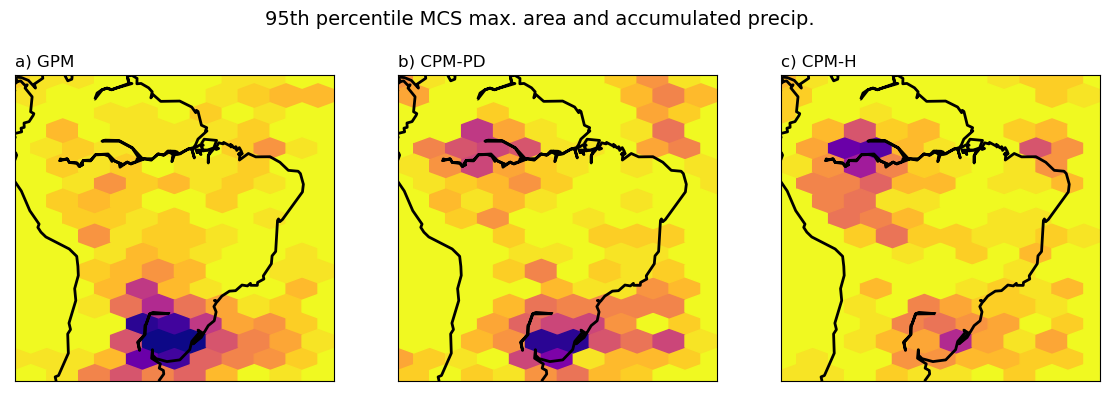

In [11]:
x_o = obs.initiation_lon[(obs.max_num >= (np.percentile(obs.max_num, 95))) & (obs.accumulated_precip >= (np.percentile(obs.accumulated_precip, 95)))]
y_o = obs.initiation_lat[(obs.max_num >= (np.percentile(obs.max_num, 95))) & (obs.accumulated_precip >= (np.percentile(obs.accumulated_precip, 95)))]

x_f = cpm_h.initiation_lon[(cpm_h.max_num >= (np.percentile(cpm_h.max_num, 95))) & (cpm_h.accumulated_precip >= (np.percentile(cpm_h.accumulated_precip, 95)))]
y_f = cpm_h.initiation_lat[(cpm_h.max_num >= (np.percentile(cpm_h.max_num, 95))) & (cpm_h.accumulated_precip >= (np.percentile(cpm_h.accumulated_precip, 95)))]

x_pd = cpm_pd.initiation_lon[(cpm_pd.max_num >= (np.percentile(cpm_pd.max_num, 95))) & (cpm_pd.accumulated_precip >= (np.percentile(cpm_pd.accumulated_precip, 95)))]
y_pd = cpm_pd.initiation_lat[(cpm_pd.max_num >= (np.percentile(cpm_pd.max_num, 95))) & (cpm_pd.accumulated_precip >= (np.percentile(cpm_pd.accumulated_precip, 95)))]

fig = plt.figure(figsize=(14, 4.5))

ax1 = plt.subplot(1,3,1)
m = Basemap(llcrnrlon=-80, llcrnrlat=-38,urcrnrlon=-30, urcrnrlat=10) # create Basemap object
m.drawcoastlines(linewidth=2) # draw coastlines
hx_o = m.hexbin(x_o, y_o, gridsize=(10,10), cmap='plasma_r',vmin=0,vmax=20, extent=(-80, -30, -40, 15))
plt.title('a) GPM', loc='left')

ax2 = plt.subplot(1,3,2)
m = Basemap(llcrnrlon=-80, llcrnrlat=-38,urcrnrlon=-30, urcrnrlat=10) # create Basemap object
m.drawcoastlines(linewidth=2) # draw coastlines
hx_pd = m.hexbin(x_pd, y_pd, gridsize=(10,10), cmap='plasma_r',vmin=0,vmax=20, extent=(-80, -30, -40, 15))
plt.title('b) CPM-PD', loc='left')

ax3 = plt.subplot(1,3,3)
m = Basemap(llcrnrlon=-80, llcrnrlat=-38,urcrnrlon=-30, urcrnrlat=10) # create Basemap object
m.drawcoastlines(linewidth=2) # draw coastlines
hx_pd = m.hexbin(x_f, y_f, gridsize=(10,10), cmap='plasma_r',vmin=0,vmax=20, extent=(-80, -30, -40, 15))
plt.title('c) CPM-H', loc='left')


plt.suptitle('95th percentile MCS max. area and accumulated precip.', fontsize=14)



## Subsetting these dataframes (extreme mcss by 95p max size AND total precip) to save and run through make_CCPFF_masks.py to make masks) ##

In [20]:
## load in full CCFP dataframes (not just per_mcs) 
obs_full = pd.read_hdf('/project/cssp_brazil/mcs_tracking_HG/OBS_TRACKS/final_tracks_obs/merged/all_years_combined_CCPF/all_years_CCPF.hdf', 'table')

for year in np.arange(2001,2008):
    print(year)
    
    extreme_obs_cells =  obs.cell[(obs.max_num >= (np.percentile(obs.max_num, 95))) & (obs.accumulated_precip >= (np.percentile(obs.accumulated_precip, 95))) & (obs.year == year)].tolist()
    
    ## filter dataframe for just the extreme_pd_cells
    extreme_obs_full_df = obs_full[obs_full.cell.isin(extreme_obs_cells)]
    extreme_obs_full_df

    ## save dataframe for MOST EXTREME (BY SIZE AND TOTAL PRECIP) MCSS IN CPM_PD ONLY ##
    extreme_obs_full_df.to_hdf('/project/cssp_brazil/mcs_tracking_HG/OBS_TRACKS/final_tracks_obs/merged/all_years_combined_CCPF/extreme_mcss_n95/extreme_mcss_obs_{}.hdf'.format(year), 'table')

## can now use make_CCPF_masks.py in /analysis to run this dataframe through and create masks for the extreme MCSs only ## ...

2001
2002
2003
2004
2005
2006
2007


In [22]:
## load in full CCFP dataframes (not just per_mcs) 
cpm_h_full = pd.read_hdf('/project/cssp_brazil/mcs_tracking_HG/CPM_HINDCAST_TRACKS/final_tracks_CPM_INTERP/merged/all_years_combined_CCPF/all_years_CCPF_cpm_hindcast.hdf', 'table')

for year in np.arange(2001,2008):
    
    extreme_h_cells = cpm_h.cell[(cpm_h.max_num >= (np.percentile(cpm_h.max_num, 95))) & (cpm_h.accumulated_precip >= (np.percentile(cpm_h.accumulated_precip, 95))) & (cpm_h.year == year)].tolist()
    
    ## filter dataframe for just the extreme_pd_cells
    extreme_h_full_df = cpm_h_full[cpm_h_full.cell.isin(extreme_h_cells)]
    extreme_h_full_df

    ## save dataframe for MOST EXTREME (BY SIZE AND TOTAL PRECIP) MCSS IN CPM_PD ONLY ##
    extreme_h_full_df.to_hdf('/project/cssp_brazil/mcs_tracking_HG/CPM_HINDCAST_TRACKS/final_tracks_CPM_INTERP/merged/all_years_combined_CCPF/extreme_mcss_n95/extreme_mcss_h_{}.hdf'.format(year), 'table')

## can now use make_CCPF_masks.py in /analysis to run this dataframe through and create masks for the extreme MCSs only ## ...

In [25]:
## load in full CCFP dataframes (not just per_mcs) 
cpm_pd_full = pd.read_hdf('/project/cssp_brazil/mcs_tracking_HG/CPM_PD_TRACKS/final_tracks_INTERP/merged/all_years_combined_CCPF/all_years_CCPF.hdf', 'table')

for year in np.arange(2001,2008):
    print(year)
    
    extreme_pd_cells = cpm_pd.cell[(cpm_pd.max_num >= (np.percentile(cpm_pd.max_num, 95))) & (cpm_pd.accumulated_precip >= (np.percentile(cpm_pd.accumulated_precip, 95))) & (cpm_pd.year == year)].tolist()

    ## filter dataframe for just the extreme_pd_cells
    extreme_pd_full_df = cpm_pd_full[cpm_pd_full.cell.isin(extreme_pd_cells)]
    extreme_pd_full_df

    ## save dataframe for MOST EXTREME (BY SIZE AND TOTAL PRECIP) MCSS IN CPM_PD ONLY ##
    extreme_pd_full_df.to_hdf('/project/cssp_brazil/mcs_tracking_HG/CPM_PD_TRACKS/final_tracks_INTERP/merged/all_years_combined_CCPF/extreme_mcss_n95/extreme_mcss_pd_{}.hdf'.format(year), 'table')

## can now use make_CCPF_masks.py in /analysis to run this dataframe through and create masks for the extreme MCSs only ## ...

2001
2002
2003
2004
2005
2006
2007


# Plotting finalised extreme MCS masks (after running extreme_mcs.py bash scripts) #

## CPM-PD ##

In [3]:
import xarray as xr
import numpy as np

## LOAD IN MASK FILES ##
pd_mask_2001 = xr.open_dataset('/project/cssp_brazil/mcs_tracking_HG/CPM_PD_TRACKS/segmentation/segmentation_yearly_2001_N95_EXTREME_MCSS.nc')
pd_mask_2001 = pd_mask_2001.segmentation_mask
pd_mask_2001

pd_mask_2002 = xr.open_dataset('/project/cssp_brazil/mcs_tracking_HG/CPM_PD_TRACKS/segmentation/segmentation_yearly_2002_N95_EXTREME_MCSS.nc')
pd_mask_2002 = pd_mask_2002.segmentation_mask
pd_mask_2002

pd_mask_2003 = xr.open_dataset('/project/cssp_brazil/mcs_tracking_HG/CPM_PD_TRACKS/segmentation/segmentation_yearly_2003_N95_EXTREME_MCSS.nc')
pd_mask_2003 = pd_mask_2003.segmentation_mask
pd_mask_2003

pd_mask_2004 = xr.open_dataset('/project/cssp_brazil/mcs_tracking_HG/CPM_PD_TRACKS/segmentation/segmentation_yearly_2004_N95_EXTREME_MCSS.nc')
pd_mask_2004 = pd_mask_2004.segmentation_mask
pd_mask_2004

pd_mask_2005 = xr.open_dataset('/project/cssp_brazil/mcs_tracking_HG/CPM_PD_TRACKS/segmentation/segmentation_yearly_2005_N95_EXTREME_MCSS.nc')
pd_mask_2005 = pd_mask_2005.segmentation_mask
pd_mask_2005

pd_mask_2006 = xr.open_dataset('/project/cssp_brazil/mcs_tracking_HG/CPM_PD_TRACKS/segmentation/segmentation_yearly_2006_N95_EXTREME_MCSS.nc')
pd_mask_2006 = pd_mask_2006.segmentation_mask
pd_mask_2006

pd_mask_2007 = xr.open_dataset('/project/cssp_brazil/mcs_tracking_HG/CPM_PD_TRACKS/segmentation/segmentation_yearly_2007_N95_EXTREME_MCSS.nc')
pd_mask_2007 = pd_mask_2007.segmentation_mask
pd_mask_2007

<xarray.DataArray 'segmentation_mask' (time: 8616, latitude: 550, longitude: 550)>
[2606340000 values with dtype=int32]
Coordinates:
  * time       (time) object 2007-01-01 00:30:00 ... 2007-12-29 23:30:00
  * latitude   (latitude) float64 -39.95 -39.85 -39.75 ... 14.75 14.85 14.95
  * longitude  (longitude) float64 -84.95 -84.85 -84.75 ... -30.25 -30.15 -30.05
Attributes:
    long_name:     segmentation_mask
    units:         1
    grid_mapping:  latitude_longitude

In [4]:
pd_mask_count_2001 = pd_mask_2001.where(pd_mask_2001 > 0).count(dim='time')

In [5]:
pd_mask_count_2002 = pd_mask_2002.where(pd_mask_2002 > 0).count(dim='time')

In [6]:
pd_mask_count_2003 = pd_mask_2003.where(pd_mask_2003 > 0).count(dim='time')

In [7]:
pd_mask_count_2004 = pd_mask_2004.where(pd_mask_2004 > 0).count(dim='time')

In [8]:
pd_mask_count_2005 = pd_mask_2005.where(pd_mask_2005 > 0).count(dim='time')

In [9]:
pd_mask_count_2006 = pd_mask_2006.where(pd_mask_2006 > 0).count(dim='time')

In [10]:
pd_mask_count_2007 = pd_mask_2007.where(pd_mask_2007 > 0).count(dim='time')

In [11]:
pd_mask_count = xr.concat([pd_mask_count_2001, pd_mask_count_2002, pd_mask_count_2003, pd_mask_count_2004, pd_mask_count_2005, pd_mask_count_2006, pd_mask_count_2007], dim='time')

In [12]:
pd_mask_count_2001_2007 = pd_mask_count.sum(dim='time')

In [13]:
pd_mask_count_2001_2007.to_netcdf('/project/cssp_brazil/mcs_tracking_HG/CPM_PD_TRACKS/segmentation/hours_with_mask/pd_mask_hours_EXTREME_N95.nc')

## OBS ##

In [2]:
## LOAD IN MASK FILES ##
obs_mask_2001 = xr.open_dataset('/project/cssp_brazil/mcs_tracking_HG/OBS_TRACKS/segmentation_obs/segmentation_yearly_2001_N95_EXTREME_MCSS.nc')
obs_mask_2001 = obs_mask_2001.segmentation_mask
obs_mask_2001

obs_mask_2002 = xr.open_dataset('/project/cssp_brazil/mcs_tracking_HG/OBS_TRACKS/segmentation_obs/segmentation_yearly_2002_N95_EXTREME_MCSS.nc')
obs_mask_2002 = obs_mask_2002.segmentation_mask
obs_mask_2002

obs_mask_2003 = xr.open_dataset('/project/cssp_brazil/mcs_tracking_HG/OBS_TRACKS/segmentation_obs/segmentation_yearly_2003_N95_EXTREME_MCSS.nc')
obs_mask_2003 = obs_mask_2003.segmentation_mask
obs_mask_2003

obs_mask_2004 = xr.open_dataset('/project/cssp_brazil/mcs_tracking_HG/OBS_TRACKS/segmentation_obs/segmentation_yearly_2004_N95_EXTREME_MCSS.nc')
obs_mask_2004 = obs_mask_2004.segmentation_mask
obs_mask_2004

obs_mask_2005 = xr.open_dataset('/project/cssp_brazil/mcs_tracking_HG/OBS_TRACKS/segmentation_obs/segmentation_yearly_2005_N95_EXTREME_MCSS.nc')
obs_mask_2005 = obs_mask_2005.segmentation_mask
obs_mask_2005

obs_mask_2006 = xr.open_dataset('/project/cssp_brazil/mcs_tracking_HG/OBS_TRACKS/segmentation_obs/segmentation_yearly_2006_N95_EXTREME_MCSS.nc')
obs_mask_2006 = obs_mask_2006.segmentation_mask
obs_mask_2006

obs_mask_2007 = xr.open_dataset('/project/cssp_brazil/mcs_tracking_HG/OBS_TRACKS/segmentation_obs/segmentation_yearly_2007_N95_EXTREME_MCSS.nc')
obs_mask_2007 = obs_mask_2007.segmentation_mask
obs_mask_2007

<xarray.DataArray 'segmentation_mask' (time: 8760, latitude: 550, longitude: 600)>
[2890800000 values with dtype=int32]
Coordinates:
  * time       (time) datetime64[ns] 2007-01-01T00:30:00 ... 2007-12-31T23:30:00
  * latitude   (latitude) float64 -39.95 -39.85 -39.75 ... 14.75 14.85 14.95
  * longitude  (longitude) float64 -89.95 -89.85 -89.75 ... -30.25 -30.15 -30.05
Attributes:
    long_name:  segmentation_mask
    units:      1

In [3]:
obs_mask_count_2001 = obs_mask_2001.where(obs_mask_2001 > 0).count(dim='time')

In [4]:
obs_mask_count_2002 = obs_mask_2002.where(obs_mask_2002 > 0).count(dim='time')

In [5]:
obs_mask_count_2003 = obs_mask_2003.where(obs_mask_2003 > 0).count(dim='time')

In [6]:
obs_mask_count_2004 = obs_mask_2004.where(obs_mask_2004 > 0).count(dim='time')

In [7]:
obs_mask_count_2005 = obs_mask_2005.where(obs_mask_2005 > 0).count(dim='time')

In [8]:
obs_mask_count_2006 = obs_mask_2006.where(obs_mask_2006 > 0).count(dim='time')

In [9]:
obs_mask_count_2007 = obs_mask_2007.where(obs_mask_2007 > 0).count(dim='time')

In [10]:
obs_mask_count = xr.concat([obs_mask_count_2001, obs_mask_count_2002, obs_mask_count_2003, obs_mask_count_2004, obs_mask_count_2005, obs_mask_count_2006, obs_mask_count_2007], dim='time')

In [11]:
obs_mask_count_2001_2007 = obs_mask_count.sum(dim='time')

In [12]:
obs_mask_count_2001_2007.to_netcdf('/project/cssp_brazil/mcs_tracking_HG/OBS_TRACKS/segmentation_obs/hours_with_mask/obs_mask_hours_EXTREME_N95.nc')

## CPM-H ##

In [13]:
## LOAD IN MASK FILES ##
h_mask_2001 = xr.open_dataset('/project/cssp_brazil/mcs_tracking_HG/CPM_HINDCAST_TRACKS/segmentation_cpm/segmentation_yearly_2001_N95_EXTREME_MCSS.nc')
h_mask_2001 = h_mask_2001.segmentation_mask
h_mask_2001

h_mask_2002 = xr.open_dataset('/project/cssp_brazil/mcs_tracking_HG/CPM_HINDCAST_TRACKS/segmentation_cpm/segmentation_yearly_2002_N95_EXTREME_MCSS.nc')
h_mask_2002 = h_mask_2002.segmentation_mask
h_mask_2002

h_mask_2003 = xr.open_dataset('/project/cssp_brazil/mcs_tracking_HG/CPM_HINDCAST_TRACKS/segmentation_cpm/segmentation_yearly_2003_N95_EXTREME_MCSS.nc')
h_mask_2003 = h_mask_2003.segmentation_mask
h_mask_2003

h_mask_2004 = xr.open_dataset('/project/cssp_brazil/mcs_tracking_HG/CPM_HINDCAST_TRACKS/segmentation_cpm/segmentation_yearly_2004_N95_EXTREME_MCSS.nc')
h_mask_2004 = h_mask_2004.segmentation_mask
h_mask_2004

h_mask_2005 = xr.open_dataset('/project/cssp_brazil/mcs_tracking_HG/CPM_HINDCAST_TRACKS/segmentation_cpm/segmentation_yearly_2005_N95_EXTREME_MCSS.nc')
h_mask_2005 = h_mask_2005.segmentation_mask
h_mask_2005

h_mask_2006 = xr.open_dataset('/project/cssp_brazil/mcs_tracking_HG/CPM_HINDCAST_TRACKS/segmentation_cpm/segmentation_yearly_2006_N95_EXTREME_MCSS.nc')
h_mask_2006 = h_mask_2006.segmentation_mask
h_mask_2006

h_mask_2007 = xr.open_dataset('/project/cssp_brazil/mcs_tracking_HG/CPM_HINDCAST_TRACKS/segmentation_cpm/segmentation_yearly_2007_N95_EXTREME_MCSS.nc')
h_mask_2007 = h_mask_2007.segmentation_mask
h_mask_2007

<xarray.DataArray 'segmentation_mask' (time: 8760, latitude: 550, longitude: 600)>
[2890800000 values with dtype=int32]
Coordinates:
  * time       (time) datetime64[ns] 2007-01-01T00:30:00 ... 2007-12-31T23:30:00
  * latitude   (latitude) float64 -39.95 -39.85 -39.75 ... 14.75 14.85 14.95
  * longitude  (longitude) float64 -89.95 -89.85 -89.75 ... -30.25 -30.15 -30.05
Attributes:
    long_name:     segmentation_mask
    units:         1
    grid_mapping:  latitude_longitude

In [14]:
h_mask_count_2001 = h_mask_2001.where(h_mask_2001 > 0).count(dim='time')

In [15]:
h_mask_count_2002 = h_mask_2002.where(h_mask_2002 > 0).count(dim='time')

In [16]:
h_mask_count_2003 = h_mask_2003.where(h_mask_2003 > 0).count(dim='time')

In [17]:
h_mask_count_2004 = h_mask_2004.where(h_mask_2004 > 0).count(dim='time')

In [18]:
h_mask_count_2005 = h_mask_2005.where(h_mask_2005 > 0).count(dim='time')

In [19]:
h_mask_count_2006 = h_mask_2006.where(h_mask_2006 > 0).count(dim='time')

In [20]:
h_mask_count_2007 = h_mask_2007.where(h_mask_2007 > 0).count(dim='time')

In [21]:
h_mask_count = xr.concat([h_mask_count_2001, h_mask_count_2002, h_mask_count_2003, h_mask_count_2004, h_mask_count_2005, h_mask_count_2006, h_mask_count_2007], dim='time')

In [22]:
h_mask_count_2001_2007 = h_mask_count.sum(dim='time')

In [23]:
h_mask_count_2001_2007.to_netcdf('/project/cssp_brazil/mcs_tracking_HG/CPM_HINDCAST_TRACKS/segmentation_cpm/hours_with_mask/cpm_hours_mask_EXTREME_N95.nc')

## Plotting ##

In [43]:
### load in files ###
cpm_pd = xr.open_dataarray('/project/cssp_brazil/mcs_tracking_HG/CPM_PD_TRACKS/segmentation/hours_with_mask/pd_mask_hours_EXTREME_N95.nc')
obs = xr.open_dataarray('/project/cssp_brazil/mcs_tracking_HG/OBS_TRACKS/segmentation_obs/hours_with_mask/obs_mask_hours_EXTREME_N95.nc')
cpm_h = xr.open_dataarray('/project/cssp_brazil/mcs_tracking_HG/CPM_HINDCAST_TRACKS/segmentation_cpm/hours_with_mask/cpm_hours_mask_EXTREME_N95.nc')

diff_pd_obs = cpm_pd - obs
diff_h_obs = cpm_h - obs
dif_pd_h = cpm_pd - cpm_h

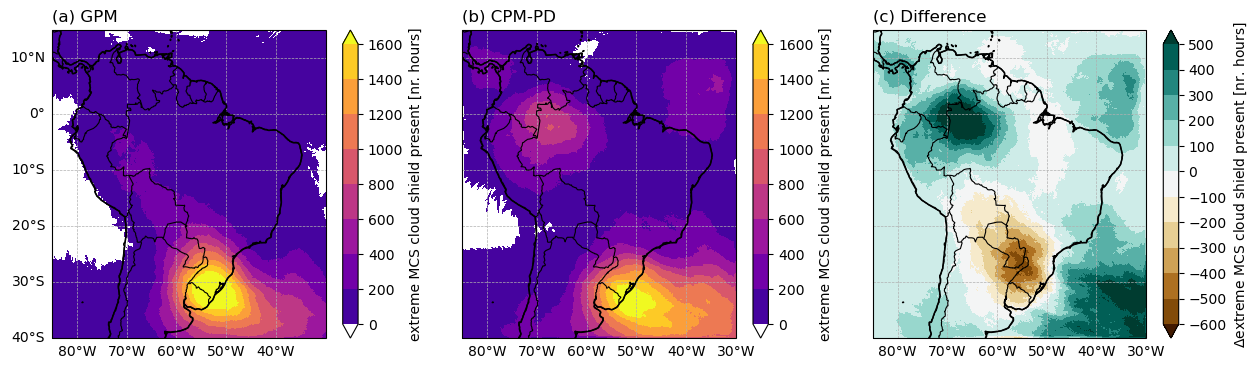

In [44]:
import matplotlib as mpl
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

levels = [0.1, 200, 400, 600, 800, 1000, 1200, 1400, 1600]
levelsdiff = np.arange(-600, 600, 100)


proj = ccrs.PlateCarree()

cmap = mpl.cm.plasma.with_extremes(under='white')
cmap_diff = mpl.cm.BrBG.with_extremes(under='#411900')
resolution = '50m'
land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
borders = cfeature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', resolution)


fig, geo_axes = plt.subplots(figsize=(15, 4), nrows=1, ncols=3, subplot_kw=dict(projection=proj))

o = obs.plot(levels=levels, ax=geo_axes[0],cmap=cmap, cbar_kwargs={'ticks': levels, 'label': f'extreme MCS cloud shield present [nr. hours]', 'extend': 'both'})
geo_axes[0].coastlines()
geo_axes[0].set_title(f'(a) GPM', loc='left')
geo_axes[0].add_feature(borders, edgecolor='k', facecolor='none', linewidth=0.8, zorder=3)
geo_axes[0].add_feature(land, facecolor='none', edgecolor='k', zorder=3)
geo_axes[0].set_aspect('auto', adjustable=None)
geo_axes[0].set_xlim(-85, -30)
# Set up grid lines and labels
gl = geo_axes[0].gridlines(crs=proj, draw_labels=True, linestyle='--', linewidth=0.5)
gl.right_labels = False
gl.top_labels = False
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()        
geo_axes[0].xaxis.set_major_formatter(lon_formatter)
geo_axes[0].yaxis.set_major_formatter(lat_formatter)

pd = cpm_pd.plot(levels=levels, ax=geo_axes[1],cmap=cmap, cbar_kwargs={'ticks': levels, 'label': f'extreme MCS cloud shield present [nr. hours]', 'extend': 'both'})
geo_axes[1].coastlines()
geo_axes[1].set_title(f'(b) CPM-PD', loc='left')
geo_axes[1].add_feature(borders, edgecolor='k', facecolor='none', linewidth=0.8, zorder=3)
geo_axes[1].add_feature(land, facecolor='none', edgecolor='k', zorder=3)
geo_axes[1].set_aspect('auto', adjustable=None)
# Set up grid lines and labels
gl = geo_axes[1].gridlines(crs=proj, draw_labels=True, linestyle='--', linewidth=0.5)
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
lon_formatter = LongitudeFormatter(zero_direction_label=True)       
geo_axes[1].xaxis.set_major_formatter(lon_formatter)


difference = diff_pd_obs.plot(levels=levelsdiff, ax=geo_axes[2],cmap=cmap_diff, cbar_kwargs={'ticks': levelsdiff, 'label': r'$\Delta$'+'extreme MCS cloud shield present [nr. hours]', 'extend': 'both'})
geo_axes[2].coastlines()
geo_axes[2].set_title(f'(c) Difference', loc='left')
geo_axes[2].add_feature(borders, edgecolor='k', facecolor='none', linewidth=0.8, zorder=3)
geo_axes[2].add_feature(land, facecolor='none', edgecolor='k', zorder=3)
geo_axes[2].set_aspect('auto', adjustable=None)
# Set up grid lines and labels
gl = geo_axes[2].gridlines(crs=proj, draw_labels=True, linestyle='--', linewidth=0.5)
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
lon_formatter = LongitudeFormatter(zero_direction_label=True)       
geo_axes[2].xaxis.set_major_formatter(lon_formatter)



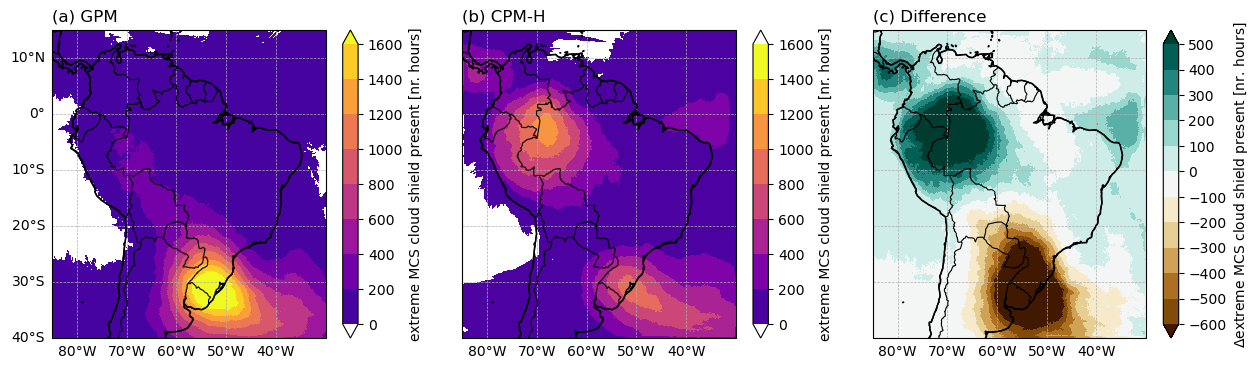

In [45]:
import matplotlib as mpl
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

levels = [0.1, 200, 400, 600, 800, 1000, 1200, 1400, 1600]
levelsdiff = np.arange(-600, 600, 100)


proj = ccrs.PlateCarree()

cmap = mpl.cm.plasma.with_extremes(under='white')
cmap_diff = mpl.cm.BrBG.with_extremes(under='#411900')
resolution = '50m'
land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
borders = cfeature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', resolution)


fig, geo_axes = plt.subplots(figsize=(15, 4), nrows=1, ncols=3, subplot_kw=dict(projection=proj))

o = obs.plot(levels=levels, ax=geo_axes[0],cmap=cmap, cbar_kwargs={'ticks': levels, 'label': f'extreme MCS cloud shield present [nr. hours]', 'extend': 'both'})
geo_axes[0].coastlines()
geo_axes[0].set_title(f'(a) GPM', loc='left')
geo_axes[0].add_feature(borders, edgecolor='k', facecolor='none', linewidth=0.8, zorder=3)
geo_axes[0].add_feature(land, facecolor='none', edgecolor='k', zorder=3)
geo_axes[0].set_aspect('auto', adjustable=None)
geo_axes[0].set_xlim(-85, -30)
# Set up grid lines and labels
gl = geo_axes[0].gridlines(crs=proj, draw_labels=True, linestyle='--', linewidth=0.5)
gl.right_labels = False
gl.top_labels = False
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()        
geo_axes[0].xaxis.set_major_formatter(lon_formatter)
geo_axes[0].yaxis.set_major_formatter(lat_formatter)

h = cpm_h.plot(levels=levels, ax=geo_axes[1],cmap=cmap, cbar_kwargs={'ticks': levels, 'label': f'extreme MCS cloud shield present [nr. hours]', 'extend': 'both'})
geo_axes[1].coastlines()
geo_axes[1].set_title(f'(b) CPM-H', loc='left')
geo_axes[1].add_feature(borders, edgecolor='k', facecolor='none', linewidth=0.8, zorder=3)
geo_axes[1].add_feature(land, facecolor='none', edgecolor='k', zorder=3)
geo_axes[1].set_aspect('auto', adjustable=None)
geo_axes[1].set_xlim(-85, -30)
# Set up grid lines and labels
gl = geo_axes[1].gridlines(crs=proj, draw_labels=True, linestyle='--', linewidth=0.5)
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
lon_formatter = LongitudeFormatter(zero_direction_label=True)       
geo_axes[1].xaxis.set_major_formatter(lon_formatter)


difference = diff_h_obs.plot(levels=levelsdiff, ax=geo_axes[2],cmap=cmap_diff, cbar_kwargs={'ticks': levelsdiff, 'label': r'$\Delta$'+'extreme MCS cloud shield present [nr. hours]', 'extend': 'both'})
geo_axes[2].coastlines()
geo_axes[2].set_title(f'(c) Difference', loc='left')
geo_axes[2].add_feature(borders, edgecolor='k', facecolor='none', linewidth=0.8, zorder=3)
geo_axes[2].add_feature(land, facecolor='none', edgecolor='k', zorder=3)
geo_axes[2].set_aspect('auto', adjustable=None)
geo_axes[2].set_xlim(-85, -30)
# Set up grid lines and labels
gl = geo_axes[2].gridlines(crs=proj, draw_labels=True, linestyle='--', linewidth=0.5)
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
lon_formatter = LongitudeFormatter(zero_direction_label=True)       
geo_axes[2].xaxis.set_major_formatter(lon_formatter)



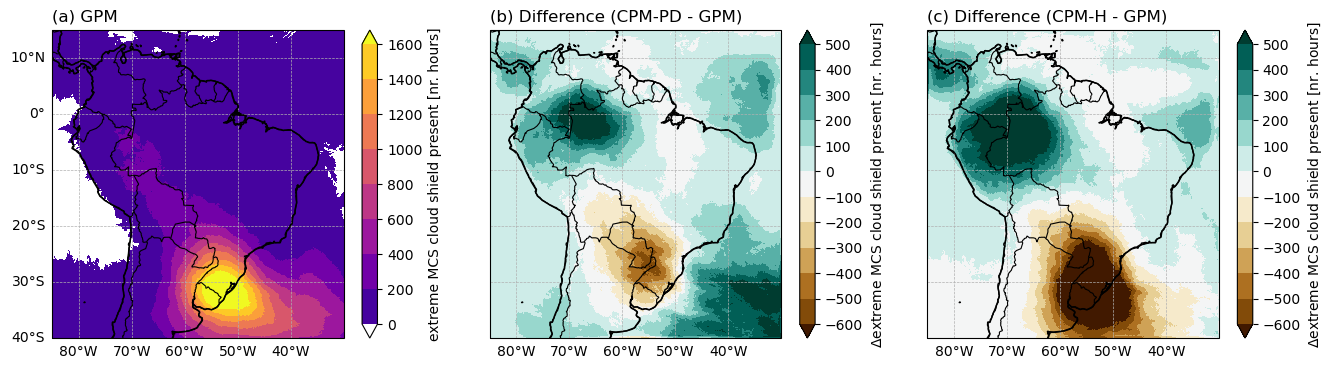

In [46]:
import matplotlib as mpl
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

levels = [0.1, 200, 400, 600, 800, 1000, 1200, 1400, 1600]
levelsdiff = np.arange(-600, 600, 100)


proj = ccrs.PlateCarree()

cmap = mpl.cm.plasma.with_extremes(under='white')
cmap_diff = mpl.cm.BrBG.with_extremes(under='#411900')
resolution = '50m'
land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
borders = cfeature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', resolution)


fig, geo_axes = plt.subplots(figsize=(16, 4), nrows=1, ncols=3, subplot_kw=dict(projection=proj))

o = obs.plot(levels=levels, ax=geo_axes[0],cmap=cmap, cbar_kwargs={'ticks': levels, 'label': 'extreme MCS cloud shield present [nr. hours]', 'extend': 'both'})
geo_axes[0].coastlines()
geo_axes[0].set_title(f'(a) GPM', loc='left')
geo_axes[0].add_feature(borders, edgecolor='k', facecolor='none', linewidth=0.8, zorder=3)
geo_axes[0].add_feature(land, facecolor='none', edgecolor='k', zorder=3)
geo_axes[0].set_aspect('auto', adjustable=None)
geo_axes[0].set_xlim(-85, -30)
# Set up grid lines and labels
gl = geo_axes[0].gridlines(crs=proj, draw_labels=True, linestyle='--', linewidth=0.5)
gl.right_labels = False
gl.top_labels = False
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()        
geo_axes[0].xaxis.set_major_formatter(lon_formatter)
geo_axes[0].yaxis.set_major_formatter(lat_formatter)

diff_pd = diff_pd_obs.plot(levels=levelsdiff, ax=geo_axes[1],cmap=cmap_diff, cbar_kwargs={'ticks': levelsdiff, 'label': '$\Delta$'+ 'extreme MCS cloud shield present [nr. hours]', 'extend': 'both'})
geo_axes[1].set_title(' ')
geo_axes[1].coastlines()
geo_axes[1].set_title(f'(b) Difference (CPM-PD - GPM)', loc='left')
geo_axes[1].add_feature(borders, edgecolor='k', facecolor='none', linewidth=0.8, zorder=3)
geo_axes[1].add_feature(land, facecolor='none', edgecolor='k', zorder=3)
geo_axes[1].set_aspect('auto', adjustable=None)
geo_axes[1].set_xlim(-85, -30)
# Set up grid lines and labels
gl = geo_axes[1].gridlines(crs=proj, draw_labels=True, linestyle='--', linewidth=0.5)
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
lon_formatter = LongitudeFormatter(zero_direction_label=True)       
geo_axes[1].xaxis.set_major_formatter(lon_formatter)


diff_h = diff_h_obs.plot(levels=levelsdiff, ax=geo_axes[2],cmap=cmap_diff, cbar_kwargs={'ticks': levelsdiff, 'label': '$\Delta$'+ 'extreme MCS cloud shield present [nr. hours]', 'extend': 'both'})
geo_axes[2].set_title(' ')
geo_axes[2].coastlines()
geo_axes[2].set_title(f'(c) Difference (CPM-H - GPM)', loc='left')
geo_axes[2].add_feature(borders, edgecolor='k', facecolor='none', linewidth=0.8, zorder=3)
geo_axes[2].add_feature(land, facecolor='none', edgecolor='k', zorder=3)
geo_axes[2].set_aspect('auto', adjustable=None)
geo_axes[2].set_xlim(-85, -30)
# Set up grid lines and labels
gl = geo_axes[2].gridlines(crs=proj, draw_labels=True, linestyle='--', linewidth=0.5)
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
lon_formatter = LongitudeFormatter(zero_direction_label=True)       
geo_axes[2].xaxis.set_major_formatter(lon_formatter)



### Percentage of total time with cloud shield (MCS frequency) ###

In [48]:
pd_all = xr.open_dataset('/project/cssp_brazil/mcs_tracking_HG/data/cpm_PD/total_precip/annual_files/regridded/combine/regridded_total_precip_2001_2007.nc')
pd_all = pd_all.unknown
pd_total_time = pd_all.shape[0]

h_all = xr.open_dataset('/project/cssp_brazil/mcs_tracking_HG/data/cpm_HINDCAST/total_precip/yearly_files/regridded/combine/regridded_total_precip_2001_2007.nc')
h_all = h_all.unknown
h_total_time = h_all.shape[0]

obs_2001_2005 = xr.open_dataset('/project/cssp_brazil/mcs_tracking_HG/data/obs/precip/combine/precip_2001_2005.nc')
obs_2001_2005 = obs_2001_2005.precipitation_flux
obs_2006_2007 = xr.open_dataset('/project/cssp_brazil/mcs_tracking_HG/data/obs/precip/combine_2006_2007/precip_2006_2007.nc')
obs_2006_2007 = obs_2006_2007.precipitationCal
obs_total_time = obs_2001_2005.shape[0] + obs_2006_2007.shape[0]


In [49]:
pd_percent = (cpm_pd / pd_total_time)*100
obs_percent = (obs / obs_total_time)*100
h_percent = (cpm_h / h_total_time)*100

In [50]:
## diffs #
diff_pd_obs = pd_percent - obs_percent
diff_h_obs = h_percent - obs_percent
diff_pd_h = pd_percent - h_percent

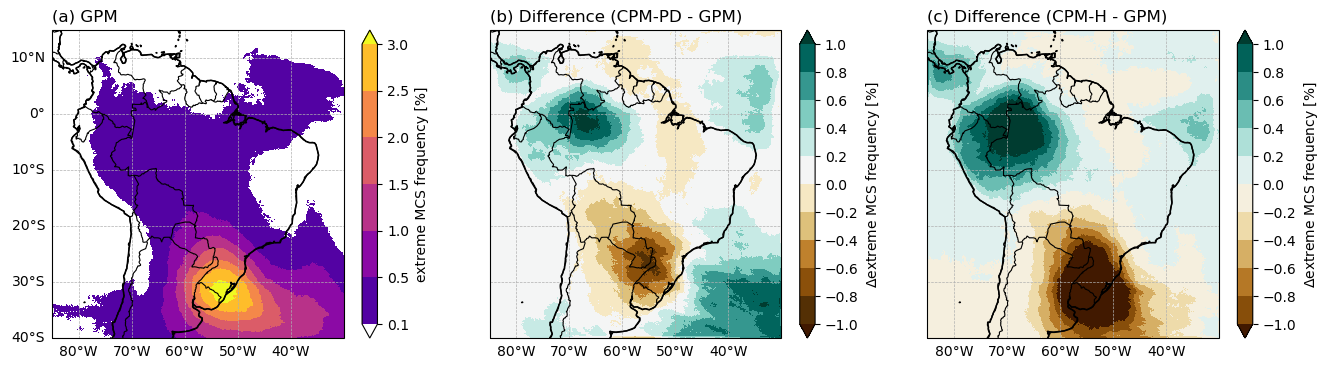

In [51]:
import matplotlib as mpl
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

levels = [0.1, 0.5, 1, 1.5, 2, 2.5, 3]
levelsdiff = np.arange(-1, 1.1, 0.2)
# Remove mid-point (0 value)
# idx = int((len(levelsdiff)-1)/2)
# levelsdiff = np.delete(levelsdiff, idx)


proj = ccrs.PlateCarree()

cmap = mpl.cm.plasma.with_extremes(under='white')
cmap_diff = mpl.cm.BrBG.with_extremes(under='#411900')
resolution = '50m'
land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
borders = cfeature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', resolution)


fig, geo_axes = plt.subplots(figsize=(16, 4), nrows=1, ncols=3, subplot_kw=dict(projection=proj))

o = obs_percent.plot(levels=levels, ax=geo_axes[0],cmap=cmap, cbar_kwargs={'ticks': levels, 'label': 'extreme MCS frequency [%]', 'extend': 'both'})
geo_axes[0].coastlines()
geo_axes[0].set_title(f'(a) GPM', loc='left')
geo_axes[0].add_feature(borders, edgecolor='k', facecolor='none', linewidth=0.8, zorder=3)
geo_axes[0].add_feature(land, facecolor='none', edgecolor='k', zorder=3)
geo_axes[0].set_aspect('auto', adjustable=None)
geo_axes[0].set_xlim(-85, -30)
# Set up grid lines and labels
gl = geo_axes[0].gridlines(crs=proj, draw_labels=True, linestyle='--', linewidth=0.5)
gl.right_labels = False
gl.top_labels = False
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()        
geo_axes[0].xaxis.set_major_formatter(lon_formatter)
geo_axes[0].yaxis.set_major_formatter(lat_formatter)

diff_pd = diff_pd_obs.plot(levels=levelsdiff, ax=geo_axes[1],cmap=cmap_diff, cbar_kwargs={'ticks': levelsdiff, 'label': '$\Delta$'+ 'extreme MCS frequency [%]', 'extend': 'both'})
geo_axes[1].set_title(' ')
geo_axes[1].coastlines()
geo_axes[1].set_title(f'(b) Difference (CPM-PD - GPM)', loc='left')
geo_axes[1].add_feature(borders, edgecolor='k', facecolor='none', linewidth=0.8, zorder=3)
geo_axes[1].add_feature(land, facecolor='none', edgecolor='k', zorder=3)
geo_axes[1].set_aspect('auto', adjustable=None)
geo_axes[1].set_xlim(-85, -30)
# Set up grid lines and labels
gl = geo_axes[1].gridlines(crs=proj, draw_labels=True, linestyle='--', linewidth=0.5)
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
lon_formatter = LongitudeFormatter(zero_direction_label=True)       
geo_axes[1].xaxis.set_major_formatter(lon_formatter)


diff_h = diff_h_obs.plot(levels=levelsdiff, ax=geo_axes[2],cmap=cmap_diff, cbar_kwargs={'ticks': levelsdiff, 'label': '$\Delta$'+ 'extreme MCS frequency [%]', 'extend': 'both'})
geo_axes[2].set_title(' ')
geo_axes[2].coastlines()
geo_axes[2].set_title(f'(c) Difference (CPM-H - GPM)', loc='left')
geo_axes[2].add_feature(borders, edgecolor='k', facecolor='none', linewidth=0.8, zorder=3)
geo_axes[2].add_feature(land, facecolor='none', edgecolor='k', zorder=3)
geo_axes[2].set_aspect('auto', adjustable=None)
geo_axes[2].set_xlim(-85, -30)
# Set up grid lines and labels
gl = geo_axes[2].gridlines(crs=proj, draw_labels=True, linestyle='--', linewidth=0.5)
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
lon_formatter = LongitudeFormatter(zero_direction_label=True)       
geo_axes[2].xaxis.set_major_formatter(lon_formatter)



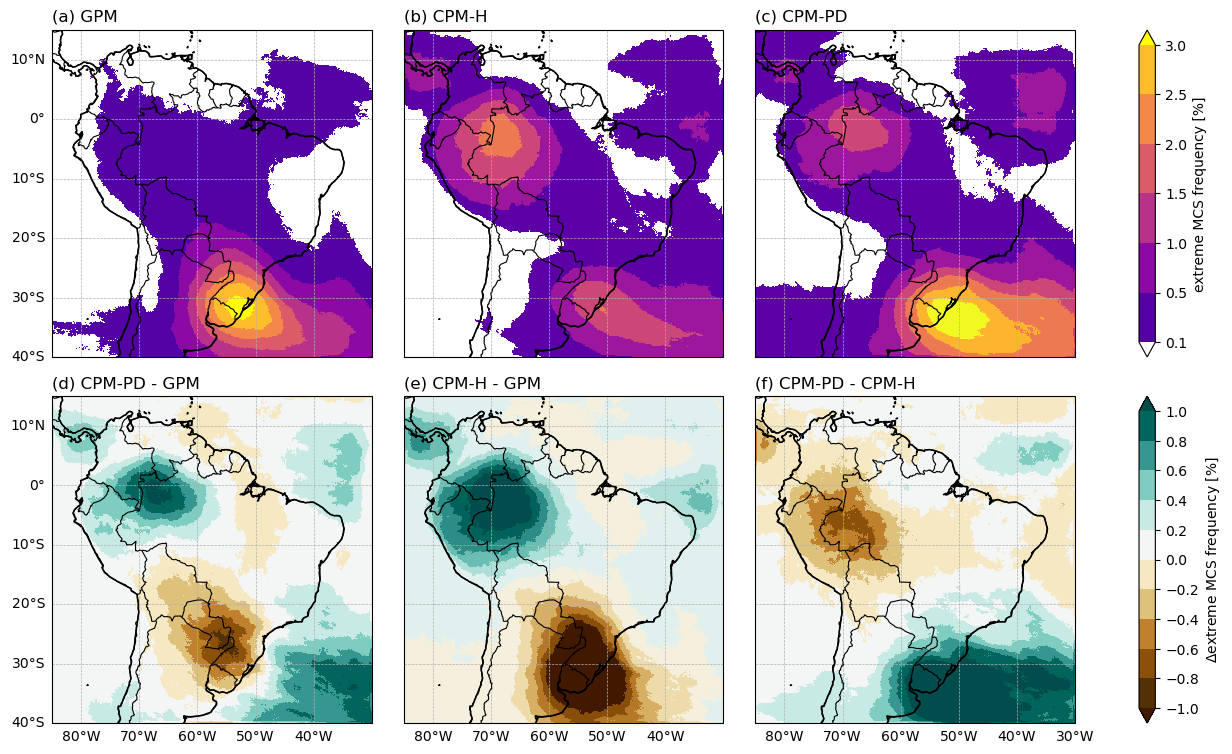

In [52]:
import matplotlib as mpl
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter


levels = [0.1, 0.5, 1, 1.5, 2, 2.5, 3]
levelsdiff = np.arange(-1, 1.1, 0.2)


proj = ccrs.PlateCarree()

cmap = mpl.cm.plasma.with_extremes(under='white', over='yellow')
#cmap = mpl.colors.ListedColormap(['white', '#a2cffe', '#658cbb', '#029386', '#75b84f', '#fac205', '#f97306', '#ef4026', '#8f1402'])
cmap_diff = mpl.cm.BrBG.with_extremes(under='#411900', over='#014d4e', bad=None)

resolution = '50m'
land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
borders = cfeature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', resolution)


fig, geo_axes = plt.subplots(figsize=(16.5, 9), nrows=2, ncols=3, subplot_kw=dict(projection=proj))

o = obs_percent.plot(levels=levels, ax=geo_axes[0, 0],cmap=cmap, add_colorbar=False)
geo_axes[0, 0].coastlines()
geo_axes[0, 0].set_title('(a) GPM', loc='left')
geo_axes[0, 0].add_feature(borders, edgecolor='k', facecolor='none', linewidth=0.8, zorder=3)
geo_axes[0, 0].add_feature(land, facecolor='none', edgecolor='k', zorder=3)
geo_axes[0, 0].set_aspect('auto', adjustable=None)
geo_axes[0, 0].set_xlim(-85, -30)
# Set up grid lines and labels
gl = geo_axes[0, 0].gridlines(crs=proj, draw_labels=True, linestyle='--', linewidth=0.5)
gl.right_labels = False
gl.top_labels = False
gl.bottom_labels = False
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()        
geo_axes[0, 0].xaxis.set_major_formatter(lon_formatter)
geo_axes[0, 0].yaxis.set_major_formatter(lat_formatter)

hindcast = h_percent.plot(levels=levels, ax=geo_axes[0, 1],cmap=cmap, add_colorbar=False)
geo_axes[0, 1].coastlines()
geo_axes[0, 1].set_title('(b) CPM-H', loc='left')
geo_axes[0, 1].add_feature(borders, edgecolor='k', facecolor='none', linewidth=0.8, zorder=3)
geo_axes[0, 1].add_feature(land, facecolor='none', edgecolor='k', zorder=3)
geo_axes[0, 1].set_aspect('auto', adjustable=None)
geo_axes[0, 1].set_xlim(-85, -30)
# Set up grid lines and labels
gl = geo_axes[0, 1].gridlines(crs=proj, draw_labels=True, linestyle='--', linewidth=0.5)
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
gl.bottom_labels = False
lon_formatter = LongitudeFormatter(zero_direction_label=True)       
geo_axes[0, 1].xaxis.set_major_formatter(lon_formatter)


present_day = pd_percent.plot(levels=levels, ax=geo_axes[0, 2], cmap=cmap, vmin=-30, vmax=30, add_colorbar=False)
geo_axes[0, 2].coastlines()
geo_axes[0, 2].set_title('(c) CPM-PD', loc='left')
geo_axes[0, 2].add_feature(borders, edgecolor='k', facecolor='none', linewidth=0.8, zorder=3)
geo_axes[0, 2].add_feature(land, facecolor='none', edgecolor='k', zorder=3)
geo_axes[0, 2].set_aspect('auto', adjustable=None)
# Set up grid lines and labels
gl = geo_axes[0, 2].gridlines(crs=proj, draw_labels=True, linestyle='--', linewidth=0.5)
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
gl.bottom_labels = False
lon_formatter = LongitudeFormatter(zero_direction_label=True)       
geo_axes[0, 2].xaxis.set_major_formatter(lon_formatter)

### differences ###
###################

pd_obs = diff_pd_obs.plot(levels=levelsdiff, ax=geo_axes[1, 0],cmap=cmap_diff, add_colorbar=False)
geo_axes[1, 0].coastlines()
geo_axes[1, 0].set_title('(d) CPM-PD - GPM', loc='left')
geo_axes[1, 0].add_feature(borders, edgecolor='k', facecolor='none', linewidth=0.8, zorder=3)
geo_axes[1, 0].add_feature(land, facecolor='none', edgecolor='k', zorder=3)
geo_axes[1, 0].set_aspect('auto', adjustable=None)
geo_axes[1, 0].set_xlim(-85, -30)
# Set up grid lines and labels
gl = geo_axes[1, 0].gridlines(crs=proj, draw_labels=True, linestyle='--', linewidth=0.5)
gl.right_labels = False
gl.top_labels = False
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()        
geo_axes[1, 0].xaxis.set_major_formatter(lon_formatter)
geo_axes[1, 0].yaxis.set_major_formatter(lat_formatter)

h_obs = diff_h_obs.plot(levels=levelsdiff, ax=geo_axes[1, 1],cmap=cmap_diff, add_colorbar=False)
geo_axes[1, 1].coastlines()
geo_axes[1, 1].set_title('(e) CPM-H - GPM', loc='left')
geo_axes[1, 1].add_feature(borders, edgecolor='k', facecolor='none', linewidth=0.8, zorder=3)
geo_axes[1, 1].add_feature(land, facecolor='none', edgecolor='k', zorder=3)
geo_axes[1, 1].set_aspect('auto', adjustable=None)
geo_axes[1, 1].set_xlim(-85, -30)
# Set up grid lines and labels
gl = geo_axes[1, 1].gridlines(crs=proj, draw_labels=True, linestyle='--', linewidth=0.5)
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
lon_formatter = LongitudeFormatter(zero_direction_label=True)       
geo_axes[1, 1].xaxis.set_major_formatter(lon_formatter)


pd_h = diff_pd_h.plot(levels=levelsdiff, ax=geo_axes[1, 2],cmap=cmap_diff, vmin=-30, vmax=30, add_colorbar=False)
geo_axes[1, 2].coastlines()
geo_axes[1, 2].set_title('(f) CPM-PD - CPM-H', loc='left')
geo_axes[1, 2].add_feature(borders, edgecolor='k', facecolor='none', linewidth=0.8, zorder=3)
geo_axes[1, 2].add_feature(land, facecolor='none', edgecolor='k', zorder=3)
geo_axes[1, 2].set_aspect('auto', adjustable=None)
# Set up grid lines and labels
gl = geo_axes[1, 2].gridlines(crs=proj, draw_labels=True, linestyle='--', linewidth=0.5)
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
lon_formatter = LongitudeFormatter(zero_direction_label=True)       
geo_axes[1, 2].xaxis.set_major_formatter(lon_formatter)

### shared colorbar ###
fig.subplots_adjust(right=0.9, wspace=0.1, hspace=0.12)
cbar = fig.colorbar(o, ax=[geo_axes[0, 0], geo_axes[0, 1], geo_axes[0, 2]], extend='both', ticks=levels)
cbar.set_label(label='extreme MCS frequency [%]')

cbar_diff = fig.colorbar(pd_obs, ax=[geo_axes[1, 0], geo_axes[1, 1], geo_axes[1, 2]], extend='both', ticks=levelsdiff)
cbar_diff.set_label(label=r'$\Delta$'+'extreme MCS frequency [%]')


# By season... #

## CPM-PD ##

In [3]:
import xarray as xr
import numpy as np

## LOAD IN MASK FILES ##
pd_mask_2001 = xr.open_dataset('/project/cssp_brazil/mcs_tracking_HG/CPM_PD_TRACKS/segmentation/segmentation_yearly_2001_N95_EXTREME_MCSS.nc')
pd_mask_2001 = pd_mask_2001.segmentation_mask
pd_mask_2001

pd_mask_2002 = xr.open_dataset('/project/cssp_brazil/mcs_tracking_HG/CPM_PD_TRACKS/segmentation/segmentation_yearly_2002_N95_EXTREME_MCSS.nc')
pd_mask_2002 = pd_mask_2002.segmentation_mask
pd_mask_2002

pd_mask_2003 = xr.open_dataset('/project/cssp_brazil/mcs_tracking_HG/CPM_PD_TRACKS/segmentation/segmentation_yearly_2003_N95_EXTREME_MCSS.nc')
pd_mask_2003 = pd_mask_2003.segmentation_mask
pd_mask_2003

pd_mask_2004 = xr.open_dataset('/project/cssp_brazil/mcs_tracking_HG/CPM_PD_TRACKS/segmentation/segmentation_yearly_2004_N95_EXTREME_MCSS.nc')
pd_mask_2004 = pd_mask_2004.segmentation_mask
pd_mask_2004

pd_mask_2005 = xr.open_dataset('/project/cssp_brazil/mcs_tracking_HG/CPM_PD_TRACKS/segmentation/segmentation_yearly_2005_N95_EXTREME_MCSS.nc')
pd_mask_2005 = pd_mask_2005.segmentation_mask
pd_mask_2005

pd_mask_2006 = xr.open_dataset('/project/cssp_brazil/mcs_tracking_HG/CPM_PD_TRACKS/segmentation/segmentation_yearly_2006_N95_EXTREME_MCSS.nc')
pd_mask_2006 = pd_mask_2006.segmentation_mask
pd_mask_2006

pd_mask_2007 = xr.open_dataset('/project/cssp_brazil/mcs_tracking_HG/CPM_PD_TRACKS/segmentation/segmentation_yearly_2007_N95_EXTREME_MCSS.nc')
pd_mask_2007 = pd_mask_2007.segmentation_mask
pd_mask_2007

<xarray.DataArray 'segmentation_mask' (time: 8616, latitude: 550, longitude: 550)>
[2606340000 values with dtype=int32]
Coordinates:
  * time       (time) object 2007-01-01 00:30:00 ... 2007-12-29 23:30:00
  * latitude   (latitude) float64 -39.95 -39.85 -39.75 ... 14.75 14.85 14.95
  * longitude  (longitude) float64 -84.95 -84.85 -84.75 ... -30.25 -30.15 -30.05
Attributes:
    long_name:     segmentation_mask
    units:         1
    grid_mapping:  latitude_longitude

In [4]:
pd_mask_2001_weighted = pd_mask_2001.where(pd_mask_2001 > 0).groupby('time.season').count(dim='time')

In [5]:
pd_mask_2002_weighted = pd_mask_2002.where(pd_mask_2002 > 0).groupby('time.season').count(dim='time')

In [6]:
pd_mask_2003_weighted = pd_mask_2003.where(pd_mask_2003 > 0).groupby('time.season').count(dim='time')

In [7]:
pd_mask_2004_weighted = pd_mask_2004.where(pd_mask_2004 > 0).groupby('time.season').count(dim='time')

In [8]:
pd_mask_2005_weighted = pd_mask_2005.where(pd_mask_2005 > 0).groupby('time.season').count(dim='time')

In [9]:
pd_mask_2006_weighted = pd_mask_2006.where(pd_mask_2006 > 0).groupby('time.season').count(dim='time')

In [10]:
pd_mask_2007_weighted = pd_mask_2007.where(pd_mask_2007 > 0).groupby('time.season').count(dim='time')

In [11]:
pd_mask_count_weighted = xr.concat([pd_mask_2001_weighted, pd_mask_2002_weighted, pd_mask_2003_weighted, pd_mask_2004_weighted, pd_mask_2005_weighted, pd_mask_2006_weighted, pd_mask_2007_weighted], dim='time')

In [12]:
pd_mask_count_weighted_seasons = pd_mask_count_weighted.sum(dim='time')

In [13]:
pd_mask_count_weighted_seasons.to_netcdf('/project/cssp_brazil/mcs_tracking_HG/CPM_PD_TRACKS/segmentation/hours_with_mask/pd_mask_hours_SEASONAL_EXTREME_N95.nc')


In [14]:
total_time = 7*3*30*24 ## 7 years, 3 months per season, 30 days per month, 24 hours per day
total_time

15120

In [15]:
pd_mask_count_weighted_seasons = pd_mask_count_weighted.sum(dim='time')

In [16]:
## convert to percenetage frequency of total time ##
pd_percent = (pd_mask_count_weighted_seasons / total_time) * 100

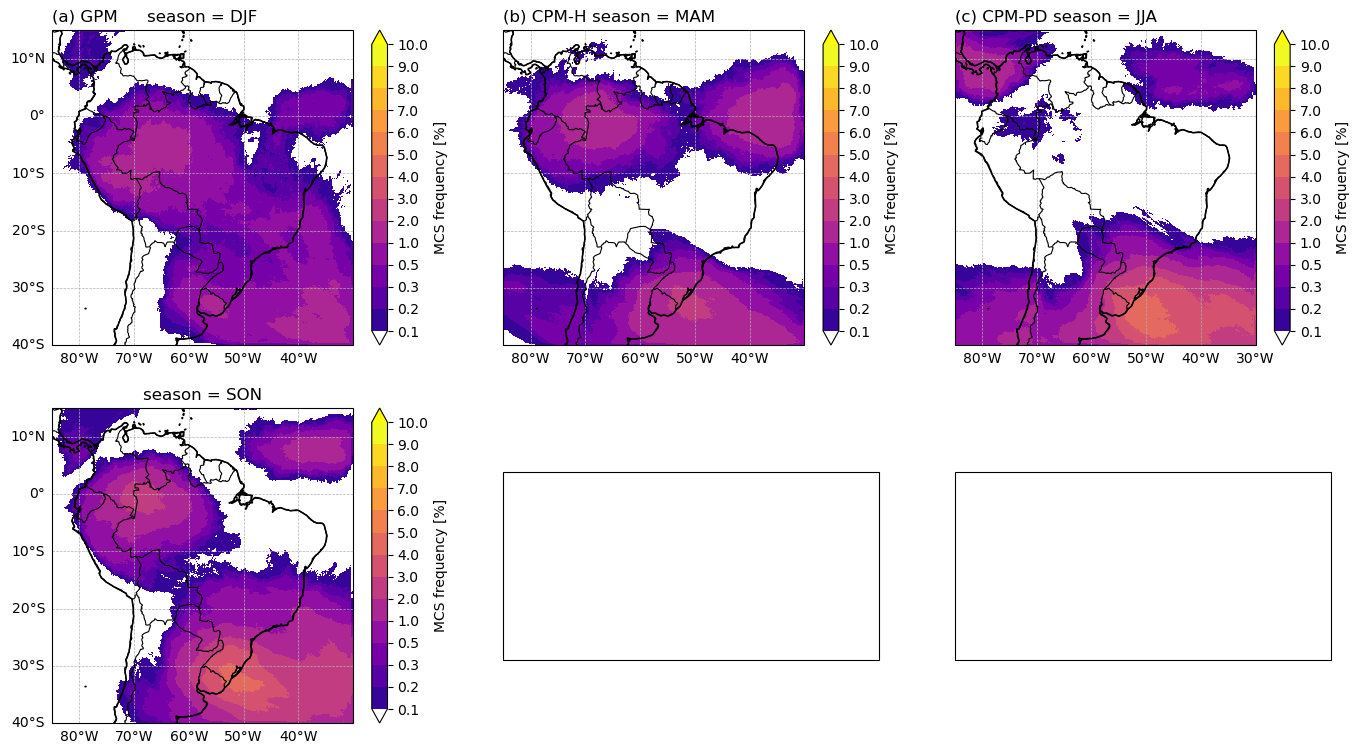

In [17]:
import matplotlib as mpl
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter


levels = [0.1, 0.2, 0.3, 0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
levelsdiff = np.arange(-3, 3.1, 0.5)


proj = ccrs.PlateCarree()

cmap = mpl.cm.plasma.with_extremes(under='white', over='yellow')
#cmap = mpl.colors.ListedColormap(['white', '#a2cffe', '#658cbb', '#029386', '#75b84f', '#fac205', '#f97306', '#ef4026', '#8f1402'])
cmap_diff = mpl.cm.BrBG.with_extremes(under='#411900', over='#014d4e', bad=None)

resolution = '50m'
land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
borders = cfeature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', resolution)


fig, geo_axes = plt.subplots(figsize=(16.5, 9), nrows=2, ncols=3, subplot_kw=dict(projection=proj))

o = pd_percent.sel(season='DJF').plot(levels=levels, ax=geo_axes[0, 0],cmap=cmap, cbar_kwargs={'ticks': levels, 'label': f'MCS frequency [%]', 'extend': 'both'})
geo_axes[0, 0].coastlines()
geo_axes[0, 0].set_title('(a) GPM', loc='left')
geo_axes[0, 0].add_feature(borders, edgecolor='k', facecolor='none', linewidth=0.8, zorder=3)
geo_axes[0, 0].add_feature(land, facecolor='none', edgecolor='k', zorder=3)
geo_axes[0, 0].set_aspect('auto', adjustable=None)
geo_axes[0, 0].set_xlim(-85, -30)
# Set up grid lines and labels
gl = geo_axes[0, 0].gridlines(crs=proj, draw_labels=True, linestyle='--', linewidth=0.5)
gl.right_labels = False
gl.top_labels = False
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()        
geo_axes[0, 0].xaxis.set_major_formatter(lon_formatter)
geo_axes[0, 0].yaxis.set_major_formatter(lat_formatter)

hindcast = pd_percent.sel(season='MAM').plot(levels=levels, ax=geo_axes[0, 1],cmap=cmap, cbar_kwargs={'ticks': levels, 'label': f'MCS frequency [%]', 'extend': 'both'})
geo_axes[0, 1].coastlines()
geo_axes[0, 1].set_title('(b) CPM-H', loc='left')
geo_axes[0, 1].add_feature(borders, edgecolor='k', facecolor='none', linewidth=0.8, zorder=3)
geo_axes[0, 1].add_feature(land, facecolor='none', edgecolor='k', zorder=3)
geo_axes[0, 1].set_aspect('auto', adjustable=None)
geo_axes[0, 1].set_xlim(-85, -30)
# Set up grid lines and labels
gl = geo_axes[0, 1].gridlines(crs=proj, draw_labels=True, linestyle='--', linewidth=0.5)
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
lon_formatter = LongitudeFormatter(zero_direction_label=True)       
geo_axes[0, 1].xaxis.set_major_formatter(lon_formatter)


present_day = pd_percent.sel(season='JJA').plot(levels=levels, ax=geo_axes[0, 2], cmap=cmap, vmin=-30, vmax=30, cbar_kwargs={'ticks': levels, 'label': 'MCS frequency [%]', 'extend': 'both'})
geo_axes[0, 2].coastlines()
geo_axes[0, 2].set_title('(c) CPM-PD', loc='left')
geo_axes[0, 2].add_feature(borders, edgecolor='k', facecolor='none', linewidth=0.8, zorder=3)
geo_axes[0, 2].add_feature(land, facecolor='none', edgecolor='k', zorder=3)
geo_axes[0, 2].set_aspect('auto', adjustable=None)
# Set up grid lines and labels
gl = geo_axes[0, 2].gridlines(crs=proj, draw_labels=True, linestyle='--', linewidth=0.5)
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
lon_formatter = LongitudeFormatter(zero_direction_label=True)       
geo_axes[0, 2].xaxis.set_major_formatter(lon_formatter)


o = pd_percent.sel(season='SON').plot(levels=levels, ax=geo_axes[1, 0],cmap=cmap, cbar_kwargs={'ticks': levels, 'label': f'MCS frequency [%]', 'extend': 'both'})
geo_axes[1, 0].coastlines()
#geo_axes[0, 0].set_title('(a) GPM', loc='left')
geo_axes[1, 0].add_feature(borders, edgecolor='k', facecolor='none', linewidth=0.8, zorder=3)
geo_axes[1, 0].add_feature(land, facecolor='none', edgecolor='k', zorder=3)
geo_axes[1, 0].set_aspect('auto', adjustable=None)
geo_axes[1, 0].set_xlim(-85, -30)
# Set up grid lines and labels
gl = geo_axes[1, 0].gridlines(crs=proj, draw_labels=True, linestyle='--', linewidth=0.5)
gl.right_labels = False
gl.top_labels = False
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()        
geo_axes[1, 0].xaxis.set_major_formatter(lon_formatter)
geo_axes[1, 0].yaxis.set_major_formatter(lat_formatter)

## OBS ##

In [4]:
## LOAD IN MASK FILES ##
obs_mask_2001 = xr.open_dataset('/project/cssp_brazil/mcs_tracking_HG/OBS_TRACKS/segmentation_obs/segmentation_yearly_2001_N95_EXTREME_MCSS.nc')
obs_mask_2001 = obs_mask_2001.segmentation_mask
obs_mask_2001

obs_mask_2002 = xr.open_dataset('/project/cssp_brazil/mcs_tracking_HG/OBS_TRACKS/segmentation_obs/segmentation_yearly_2002_N95_EXTREME_MCSS.nc')
obs_mask_2002 = obs_mask_2002.segmentation_mask
obs_mask_2002

obs_mask_2003 = xr.open_dataset('/project/cssp_brazil/mcs_tracking_HG/OBS_TRACKS/segmentation_obs/segmentation_yearly_2003_N95_EXTREME_MCSS.nc')
obs_mask_2003 = obs_mask_2003.segmentation_mask
obs_mask_2003

obs_mask_2004 = xr.open_dataset('/project/cssp_brazil/mcs_tracking_HG/OBS_TRACKS/segmentation_obs/segmentation_yearly_2004_N95_EXTREME_MCSS.nc')
obs_mask_2004 = obs_mask_2004.segmentation_mask
obs_mask_2004

obs_mask_2005 = xr.open_dataset('/project/cssp_brazil/mcs_tracking_HG/OBS_TRACKS/segmentation_obs/segmentation_yearly_2005_N95_EXTREME_MCSS.nc')
obs_mask_2005 = obs_mask_2005.segmentation_mask
obs_mask_2005

obs_mask_2006 = xr.open_dataset('/project/cssp_brazil/mcs_tracking_HG/OBS_TRACKS/segmentation_obs/segmentation_yearly_2006_N95_EXTREME_MCSS.nc')
obs_mask_2006 = obs_mask_2006.segmentation_mask
obs_mask_2006

obs_mask_2007 = xr.open_dataset('/project/cssp_brazil/mcs_tracking_HG/OBS_TRACKS/segmentation_obs/segmentation_yearly_2007_N95_EXTREME_MCSS.nc')
obs_mask_2007 = obs_mask_2007.segmentation_mask
obs_mask_2007

<xarray.DataArray 'segmentation_mask' (time: 8760, latitude: 550, longitude: 600)>
[2890800000 values with dtype=int32]
Coordinates:
  * time       (time) datetime64[ns] 2007-01-01T00:30:00 ... 2007-12-31T23:30:00
  * latitude   (latitude) float64 -39.95 -39.85 -39.75 ... 14.75 14.85 14.95
  * longitude  (longitude) float64 -89.95 -89.85 -89.75 ... -30.25 -30.15 -30.05
Attributes:
    long_name:  segmentation_mask
    units:      1

In [5]:
obs_mask_2001_weighted = obs_mask_2001.where(obs_mask_2001 > 0).groupby('time.season').count(dim='time')

In [6]:
obs_mask_2002_weighted = obs_mask_2002.where(obs_mask_2002 > 0).groupby('time.season').count(dim='time')

In [7]:
obs_mask_2003_weighted = obs_mask_2003.where(obs_mask_2003 > 0).groupby('time.season').count(dim='time')

In [8]:
obs_mask_2004_weighted = obs_mask_2004.where(obs_mask_2004 > 0).groupby('time.season').count(dim='time')

In [9]:
obs_mask_2005_weighted = obs_mask_2005.where(obs_mask_2005 > 0).groupby('time.season').count(dim='time')

In [10]:
obs_mask_2006_weighted = obs_mask_2006.where(obs_mask_2006 > 0).groupby('time.season').count(dim='time')

In [11]:
obs_mask_2007_weighted = obs_mask_2007.where(obs_mask_2007 > 0).groupby('time.season').count(dim='time')

In [12]:
obs_mask_count_weighted = xr.concat([obs_mask_2001_weighted, obs_mask_2002_weighted, obs_mask_2003_weighted, obs_mask_2004_weighted, obs_mask_2005_weighted, obs_mask_2006_weighted, obs_mask_2007_weighted], dim='time')


In [13]:
obs_mask_count_weighted_seasons = obs_mask_count_weighted.sum(dim='time')

In [14]:
obs_mask_count_weighted_seasons.to_netcdf('/project/cssp_brazil/mcs_tracking_HG/OBS_TRACKS/segmentation_obs/hours_with_mask/obs_mask_hours_SEASONAL_EXTREME_N95.nc')


In [15]:
total_time = 7*3*30*24 ## 7 years, 3 months per season, 30 days per month, 24 hours per day
total_time

15120

In [16]:
obs_mask_count_weighted_seasons = obs_mask_count_weighted.sum(dim='time')

In [17]:
## convert to percenetage frequency of total time ##
obs_percent = (obs_mask_count_weighted_seasons / total_time) * 100

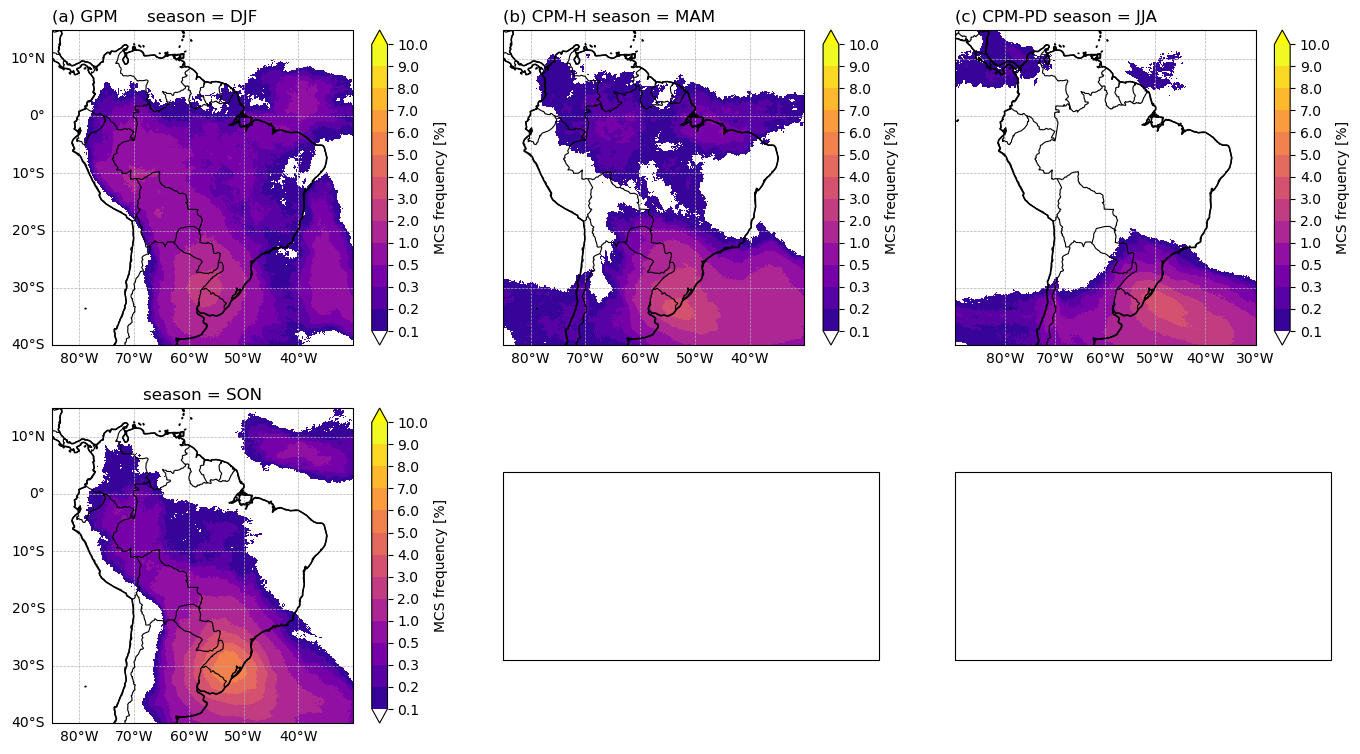

In [18]:
import matplotlib as mpl
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter


levels = [0.1, 0.2, 0.3, 0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
levelsdiff = np.arange(-3, 3.1, 0.5)


proj = ccrs.PlateCarree()

cmap = mpl.cm.plasma.with_extremes(under='white', over='yellow')
#cmap = mpl.colors.ListedColormap(['white', '#a2cffe', '#658cbb', '#029386', '#75b84f', '#fac205', '#f97306', '#ef4026', '#8f1402'])
cmap_diff = mpl.cm.BrBG.with_extremes(under='#411900', over='#014d4e', bad=None)

resolution = '50m'
land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
borders = cfeature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', resolution)


fig, geo_axes = plt.subplots(figsize=(16.5, 9), nrows=2, ncols=3, subplot_kw=dict(projection=proj))

o = obs_percent.sel(season='DJF').plot(levels=levels, ax=geo_axes[0, 0],cmap=cmap, cbar_kwargs={'ticks': levels, 'label': f'MCS frequency [%]', 'extend': 'both'})
geo_axes[0, 0].coastlines()
geo_axes[0, 0].set_title('(a) GPM', loc='left')
geo_axes[0, 0].add_feature(borders, edgecolor='k', facecolor='none', linewidth=0.8, zorder=3)
geo_axes[0, 0].add_feature(land, facecolor='none', edgecolor='k', zorder=3)
geo_axes[0, 0].set_aspect('auto', adjustable=None)
geo_axes[0, 0].set_xlim(-85, -30)
# Set up grid lines and labels
gl = geo_axes[0, 0].gridlines(crs=proj, draw_labels=True, linestyle='--', linewidth=0.5)
gl.right_labels = False
gl.top_labels = False
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()        
geo_axes[0, 0].xaxis.set_major_formatter(lon_formatter)
geo_axes[0, 0].yaxis.set_major_formatter(lat_formatter)

hindcast = obs_percent.sel(season='MAM').plot(levels=levels, ax=geo_axes[0, 1],cmap=cmap, cbar_kwargs={'ticks': levels, 'label': f'MCS frequency [%]', 'extend': 'both'})
geo_axes[0, 1].coastlines()
geo_axes[0, 1].set_title('(b) CPM-H', loc='left')
geo_axes[0, 1].add_feature(borders, edgecolor='k', facecolor='none', linewidth=0.8, zorder=3)
geo_axes[0, 1].add_feature(land, facecolor='none', edgecolor='k', zorder=3)
geo_axes[0, 1].set_aspect('auto', adjustable=None)
geo_axes[0, 1].set_xlim(-85, -30)
# Set up grid lines and labels
gl = geo_axes[0, 1].gridlines(crs=proj, draw_labels=True, linestyle='--', linewidth=0.5)
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
lon_formatter = LongitudeFormatter(zero_direction_label=True)       
geo_axes[0, 1].xaxis.set_major_formatter(lon_formatter)


present_day = obs_percent.sel(season='JJA').plot(levels=levels, ax=geo_axes[0, 2], cmap=cmap, vmin=-30, vmax=30, cbar_kwargs={'ticks': levels, 'label': 'MCS frequency [%]', 'extend': 'both'})
geo_axes[0, 2].coastlines()
geo_axes[0, 2].set_title('(c) CPM-PD', loc='left')
geo_axes[0, 2].add_feature(borders, edgecolor='k', facecolor='none', linewidth=0.8, zorder=3)
geo_axes[0, 2].add_feature(land, facecolor='none', edgecolor='k', zorder=3)
geo_axes[0, 2].set_aspect('auto', adjustable=None)
# Set up grid lines and labels
gl = geo_axes[0, 2].gridlines(crs=proj, draw_labels=True, linestyle='--', linewidth=0.5)
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
lon_formatter = LongitudeFormatter(zero_direction_label=True)       
geo_axes[0, 2].xaxis.set_major_formatter(lon_formatter)


o = obs_percent.sel(season='SON').plot(levels=levels, ax=geo_axes[1, 0],cmap=cmap, cbar_kwargs={'ticks': levels, 'label': f'MCS frequency [%]', 'extend': 'both'})
geo_axes[1, 0].coastlines()
#geo_axes[0, 0].set_title('(a) GPM', loc='left')
geo_axes[1, 0].add_feature(borders, edgecolor='k', facecolor='none', linewidth=0.8, zorder=3)
geo_axes[1, 0].add_feature(land, facecolor='none', edgecolor='k', zorder=3)
geo_axes[1, 0].set_aspect('auto', adjustable=None)
geo_axes[1, 0].set_xlim(-85, -30)
# Set up grid lines and labels
gl = geo_axes[1, 0].gridlines(crs=proj, draw_labels=True, linestyle='--', linewidth=0.5)
gl.right_labels = False
gl.top_labels = False
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()        
geo_axes[1, 0].xaxis.set_major_formatter(lon_formatter)
geo_axes[1, 0].yaxis.set_major_formatter(lat_formatter)

## CPM-H ##

In [19]:
## LOAD IN MASK FILES ##
h_mask_2001 = xr.open_dataset('/project/cssp_brazil/mcs_tracking_HG/CPM_HINDCAST_TRACKS/segmentation_cpm/segmentation_yearly_2001_N95_EXTREME_MCSS.nc')
h_mask_2001 = h_mask_2001.segmentation_mask
h_mask_2001

h_mask_2002 = xr.open_dataset('/project/cssp_brazil/mcs_tracking_HG/CPM_HINDCAST_TRACKS/segmentation_cpm/segmentation_yearly_2002_N95_EXTREME_MCSS.nc')
h_mask_2002 = h_mask_2002.segmentation_mask
h_mask_2002

h_mask_2003 = xr.open_dataset('/project/cssp_brazil/mcs_tracking_HG/CPM_HINDCAST_TRACKS/segmentation_cpm/segmentation_yearly_2003_N95_EXTREME_MCSS.nc')
h_mask_2003 = h_mask_2003.segmentation_mask
h_mask_2003

h_mask_2004 = xr.open_dataset('/project/cssp_brazil/mcs_tracking_HG/CPM_HINDCAST_TRACKS/segmentation_cpm/segmentation_yearly_2004_N95_EXTREME_MCSS.nc')
h_mask_2004 = h_mask_2004.segmentation_mask
h_mask_2004

h_mask_2005 = xr.open_dataset('/project/cssp_brazil/mcs_tracking_HG/CPM_HINDCAST_TRACKS/segmentation_cpm/segmentation_yearly_2005_N95_EXTREME_MCSS.nc')
h_mask_2005 = h_mask_2005.segmentation_mask
h_mask_2005

h_mask_2006 = xr.open_dataset('/project/cssp_brazil/mcs_tracking_HG/CPM_HINDCAST_TRACKS/segmentation_cpm/segmentation_yearly_2006_N95_EXTREME_MCSS.nc')
h_mask_2006 = h_mask_2006.segmentation_mask
h_mask_2006

h_mask_2007 = xr.open_dataset('/project/cssp_brazil/mcs_tracking_HG/CPM_HINDCAST_TRACKS/segmentation_cpm/segmentation_yearly_2007_N95_EXTREME_MCSS.nc')
h_mask_2007 = h_mask_2007.segmentation_mask
h_mask_2007

<xarray.DataArray 'segmentation_mask' (time: 8760, latitude: 550, longitude: 600)>
[2890800000 values with dtype=int32]
Coordinates:
  * time       (time) datetime64[ns] 2007-01-01T00:30:00 ... 2007-12-31T23:30:00
  * latitude   (latitude) float64 -39.95 -39.85 -39.75 ... 14.75 14.85 14.95
  * longitude  (longitude) float64 -89.95 -89.85 -89.75 ... -30.25 -30.15 -30.05
Attributes:
    long_name:     segmentation_mask
    units:         1
    grid_mapping:  latitude_longitude

In [20]:
h_mask_2001_weighted = h_mask_2001.where(h_mask_2001 > 0).groupby('time.season').count(dim='time')

In [21]:
h_mask_2002_weighted = h_mask_2002.where(h_mask_2002 > 0).groupby('time.season').count(dim='time')

In [22]:
h_mask_2003_weighted = h_mask_2003.where(h_mask_2003 > 0).groupby('time.season').count(dim='time')

In [23]:
h_mask_2004_weighted = h_mask_2004.where(h_mask_2004 > 0).groupby('time.season').count(dim='time')

In [24]:
h_mask_2005_weighted = h_mask_2005.where(h_mask_2005 > 0).groupby('time.season').count(dim='time')

In [25]:
h_mask_2006_weighted = h_mask_2006.where(h_mask_2006 > 0).groupby('time.season').count(dim='time')

In [26]:
h_mask_2007_weighted = h_mask_2007.where(h_mask_2007 > 0).groupby('time.season').count(dim='time')

In [27]:
h_mask_count_weighted = xr.concat([h_mask_2001_weighted, h_mask_2002_weighted, h_mask_2003_weighted, h_mask_2004_weighted, h_mask_2005_weighted, h_mask_2006_weighted, h_mask_2007_weighted], dim='time')


In [28]:
h_mask_count_weighted_seasons = h_mask_count_weighted.sum(dim='time')

In [29]:
h_mask_count_weighted_seasons.to_netcdf('/project/cssp_brazil/mcs_tracking_HG/CPM_HINDCAST_TRACKS/segmentation_cpm/hours_with_mask/cpm_hours_mask_SEASONAL_EXTREME_N95.nc')

In [30]:
total_time = 7*3*30*24 ## 7 years, 3 months per season, 30 days per month, 24 hours per day
total_time

15120

In [31]:
## convert to percenetage frequency of total time ##
h_percent = (h_mask_count_weighted_seasons / total_time) * 100

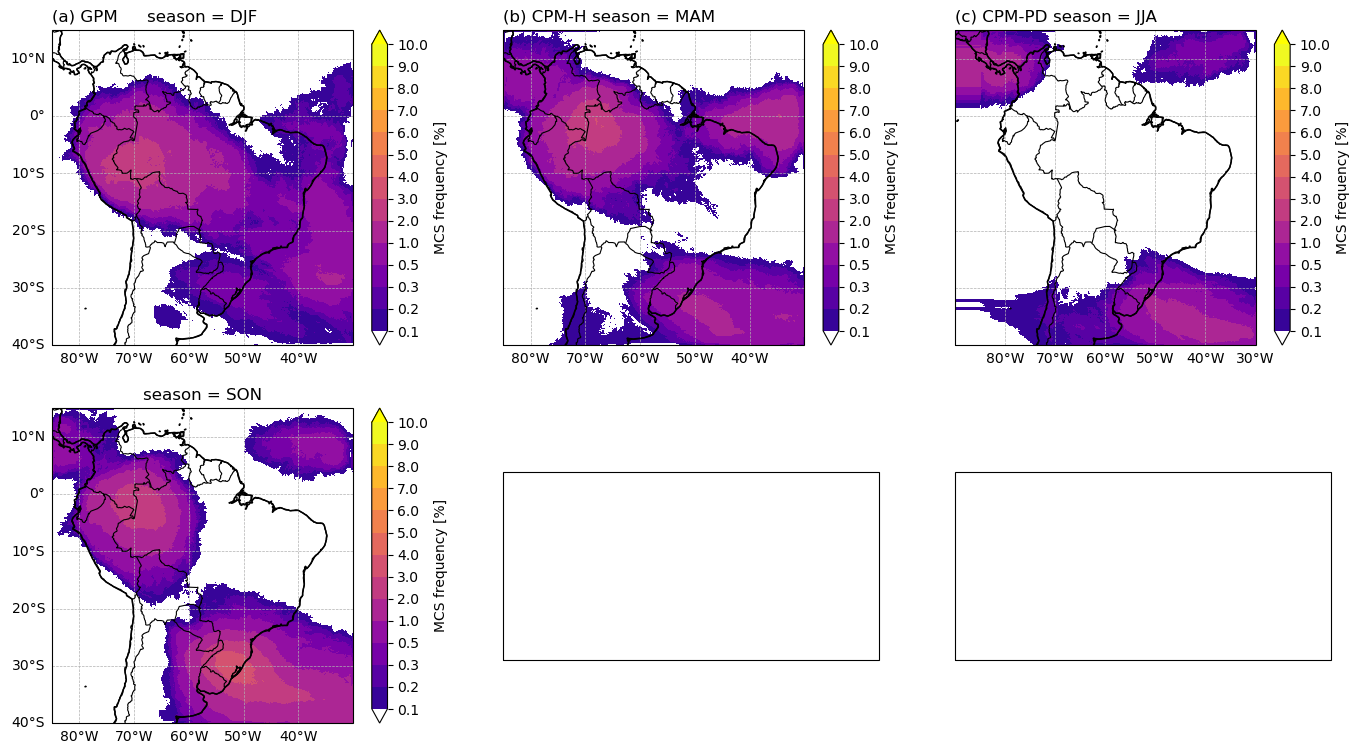

In [32]:
import matplotlib as mpl
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter


levels = [0.1, 0.2, 0.3, 0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
levelsdiff = np.arange(-3, 3.1, 0.5)


proj = ccrs.PlateCarree()

cmap = mpl.cm.plasma.with_extremes(under='white', over='yellow')
#cmap = mpl.colors.ListedColormap(['white', '#a2cffe', '#658cbb', '#029386', '#75b84f', '#fac205', '#f97306', '#ef4026', '#8f1402'])
cmap_diff = mpl.cm.BrBG.with_extremes(under='#411900', over='#014d4e', bad=None)

resolution = '50m'
land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
borders = cfeature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', resolution)


fig, geo_axes = plt.subplots(figsize=(16.5, 9), nrows=2, ncols=3, subplot_kw=dict(projection=proj))

o = h_percent.sel(season='DJF').plot(levels=levels, ax=geo_axes[0, 0],cmap=cmap, cbar_kwargs={'ticks': levels, 'label': f'MCS frequency [%]', 'extend': 'both'})
geo_axes[0, 0].coastlines()
geo_axes[0, 0].set_title('(a) GPM', loc='left')
geo_axes[0, 0].add_feature(borders, edgecolor='k', facecolor='none', linewidth=0.8, zorder=3)
geo_axes[0, 0].add_feature(land, facecolor='none', edgecolor='k', zorder=3)
geo_axes[0, 0].set_aspect('auto', adjustable=None)
geo_axes[0, 0].set_xlim(-85, -30)
# Set up grid lines and labels
gl = geo_axes[0, 0].gridlines(crs=proj, draw_labels=True, linestyle='--', linewidth=0.5)
gl.right_labels = False
gl.top_labels = False
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()        
geo_axes[0, 0].xaxis.set_major_formatter(lon_formatter)
geo_axes[0, 0].yaxis.set_major_formatter(lat_formatter)

hindcast = h_percent.sel(season='MAM').plot(levels=levels, ax=geo_axes[0, 1],cmap=cmap, cbar_kwargs={'ticks': levels, 'label': f'MCS frequency [%]', 'extend': 'both'})
geo_axes[0, 1].coastlines()
geo_axes[0, 1].set_title('(b) CPM-H', loc='left')
geo_axes[0, 1].add_feature(borders, edgecolor='k', facecolor='none', linewidth=0.8, zorder=3)
geo_axes[0, 1].add_feature(land, facecolor='none', edgecolor='k', zorder=3)
geo_axes[0, 1].set_aspect('auto', adjustable=None)
geo_axes[0, 1].set_xlim(-85, -30)
# Set up grid lines and labels
gl = geo_axes[0, 1].gridlines(crs=proj, draw_labels=True, linestyle='--', linewidth=0.5)
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
lon_formatter = LongitudeFormatter(zero_direction_label=True)       
geo_axes[0, 1].xaxis.set_major_formatter(lon_formatter)


present_day = h_percent.sel(season='JJA').plot(levels=levels, ax=geo_axes[0, 2], cmap=cmap, vmin=-30, vmax=30, cbar_kwargs={'ticks': levels, 'label': 'MCS frequency [%]', 'extend': 'both'})
geo_axes[0, 2].coastlines()
geo_axes[0, 2].set_title('(c) CPM-PD', loc='left')
geo_axes[0, 2].add_feature(borders, edgecolor='k', facecolor='none', linewidth=0.8, zorder=3)
geo_axes[0, 2].add_feature(land, facecolor='none', edgecolor='k', zorder=3)
geo_axes[0, 2].set_aspect('auto', adjustable=None)
# Set up grid lines and labels
gl = geo_axes[0, 2].gridlines(crs=proj, draw_labels=True, linestyle='--', linewidth=0.5)
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
lon_formatter = LongitudeFormatter(zero_direction_label=True)       
geo_axes[0, 2].xaxis.set_major_formatter(lon_formatter)


o = h_percent.sel(season='SON').plot(levels=levels, ax=geo_axes[1, 0],cmap=cmap, cbar_kwargs={'ticks': levels, 'label': f'MCS frequency [%]', 'extend': 'both'})
geo_axes[1, 0].coastlines()
#geo_axes[0, 0].set_title('(a) GPM', loc='left')
geo_axes[1, 0].add_feature(borders, edgecolor='k', facecolor='none', linewidth=0.8, zorder=3)
geo_axes[1, 0].add_feature(land, facecolor='none', edgecolor='k', zorder=3)
geo_axes[1, 0].set_aspect('auto', adjustable=None)
geo_axes[1, 0].set_xlim(-85, -30)
# Set up grid lines and labels
gl = geo_axes[1, 0].gridlines(crs=proj, draw_labels=True, linestyle='--', linewidth=0.5)
gl.right_labels = False
gl.top_labels = False
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()        
geo_axes[1, 0].xaxis.set_major_formatter(lon_formatter)
geo_axes[1, 0].yaxis.set_major_formatter(lat_formatter)

## Plotting ##

In [34]:
### load in files ###
cpm_pd = xr.open_dataarray('/project/cssp_brazil/mcs_tracking_HG/CPM_PD_TRACKS/segmentation/hours_with_mask/pd_mask_hours_SEASONAL_EXTREME_N95.nc')
obs = xr.open_dataarray('/project/cssp_brazil/mcs_tracking_HG/OBS_TRACKS/segmentation_obs/hours_with_mask/obs_mask_hours_SEASONAL_EXTREME_N95.nc')
cpm_h = xr.open_dataarray('/project/cssp_brazil/mcs_tracking_HG/CPM_HINDCAST_TRACKS/segmentation_cpm/hours_with_mask/cpm_hours_mask_SEASONAL_EXTREME_N95.nc')

diff_pd_obs = cpm_pd - obs
diff_h_obs = cpm_h - obs
dif_pd_h = cpm_pd - cpm_h

In [35]:
## converting to percentages of total time ##

# pd total time
pd_total_time = 7*3*30*24 ## 7 years, 3 months per season, 30 days per month, 24 hours per day
pd_total_time
pd_percent = (cpm_pd / pd_total_time)*100


In [36]:
# obs_total_time
obs_2001_2005 = xr.open_dataset('/project/cssp_brazil/mcs_tracking_HG/data/obs/precip/combine/precip_2001_2005.nc')
obs_2001_2005 = obs_2001_2005.precipitation_flux
obs_2006_2007 = xr.open_dataset('/project/cssp_brazil/mcs_tracking_HG/data/obs/precip/combine_2006_2007/precip_2006_2007.nc')
obs_2006_2007 = obs_2006_2007.precipitationCal

obs_total_time_djf = obs_2001_2005.time.dt.season.where(obs_2001_2005.time.dt.season == 'DJF').count().values + obs_2006_2007.time.dt.season.where(obs_2006_2007.time.dt.season == 'DJF').count().values
obs_total_time_mam = obs_2001_2005.time.dt.season.where(obs_2001_2005.time.dt.season == 'MAM').count().values + obs_2006_2007.time.dt.season.where(obs_2006_2007.time.dt.season == 'MAM').count().values
obs_total_time_jja = obs_2001_2005.time.dt.season.where(obs_2001_2005.time.dt.season == 'JJA').count().values + obs_2006_2007.time.dt.season.where(obs_2006_2007.time.dt.season == 'JJA').count().values
obs_total_time_son = obs_2001_2005.time.dt.season.where(obs_2001_2005.time.dt.season == 'SON').count().values + obs_2006_2007.time.dt.season.where(obs_2006_2007.time.dt.season == 'SON').count().values

obs_percent_djf = (obs.sel(season = 'DJF') / obs_total_time_djf)*100
obs_percent_mam = (obs.sel(season = 'MAM') / obs_total_time_mam)*100
obs_percent_jja = (obs.sel(season = 'JJA') / obs_total_time_jja)*100
obs_percent_son = (obs.sel(season = 'SON') / obs_total_time_son)*100

In [37]:
# cpm-h total time
h_all = xr.open_dataset('/project/cssp_brazil/mcs_tracking_HG/data/cpm_HINDCAST/total_precip/yearly_files/regridded/combine/regridded_total_precip_2001_2007.nc')
h_all = h_all.unknown

h_total_time_djf = h_all.time.dt.season.where(h_all.time.dt.season == 'DJF').count().values
h_total_time_mam = h_all.time.dt.season.where(h_all.time.dt.season == 'MAM').count().values
h_total_time_jja = h_all.time.dt.season.where(h_all.time.dt.season == 'JJA').count().values
h_total_time_son = h_all.time.dt.season.where(h_all.time.dt.season == 'SON').count().values

h_percent_djf = (cpm_h.sel(season = 'DJF') / h_total_time_djf)*100
h_percent_mam = (cpm_h.sel(season = 'MAM') / h_total_time_mam)*100
h_percent_jja = (cpm_h.sel(season = 'JJA') / h_total_time_jja)*100
h_percent_son = (cpm_h.sel(season = 'SON') / h_total_time_son)*100


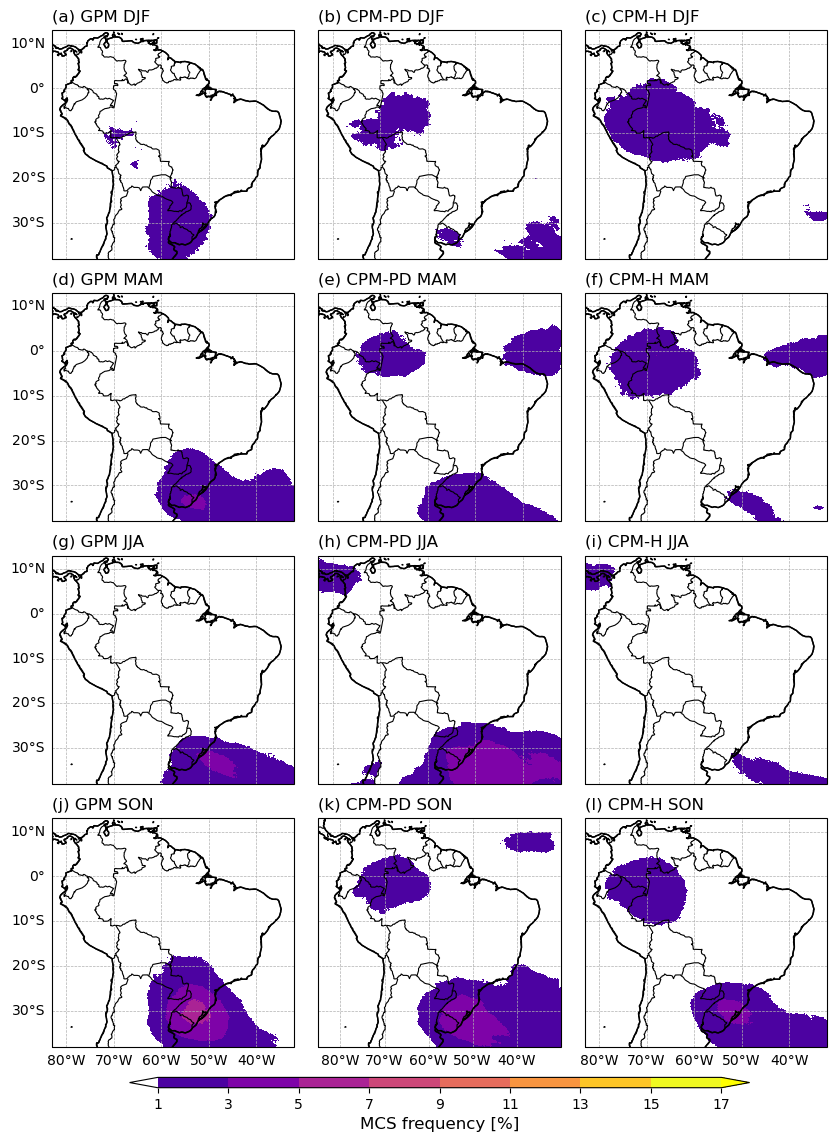

In [38]:
import matplotlib as mpl
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter


levels = [1, 3, 5, 7, 9, 11, 13, 15, 17]
levelsdiff = np.arange(-3, 3.1, 0.5)


proj = ccrs.PlateCarree()

cmap = mpl.cm.plasma.with_extremes(under='white', over='yellow')
#cmap = mpl.colors.ListedColormap(['white', '#a2cffe', '#658cbb', '#029386', '#75b84f', '#fac205', '#f97306', '#ef4026', '#8f1402'])
cmap_diff = mpl.cm.BrBG.with_extremes(under='#411900', over='#014d4e', bad=None)

resolution = '50m'
land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
borders = cfeature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', resolution)


fig, geo_axes = plt.subplots(figsize=(10, 16), nrows=4, ncols=3, subplot_kw=dict(projection=proj))

### DJF ###
###########
o_djf = obs_percent_djf.plot(levels=levels, ax=geo_axes[0, 0],cmap=cmap, add_colorbar=False)
geo_axes[0, 0].set_title(' ')
geo_axes[0, 0].coastlines()
geo_axes[0, 0].set_title('(a) GPM DJF', loc='left')
geo_axes[0, 0].add_feature(borders, edgecolor='k', facecolor='none', linewidth=0.8, zorder=3)
geo_axes[0, 0].add_feature(land, facecolor='none', edgecolor='k', zorder=3)
geo_axes[0, 0].set_aspect('auto', adjustable=None)
geo_axes[0, 0].set_xlim(-83, -32)
geo_axes[0, 0].set_ylim(-38, 13)
# Set up grid lines and labels
gl = geo_axes[0, 0].gridlines(crs=proj, draw_labels=True, linestyle='--', linewidth=0.5)
gl.right_labels = False
gl.top_labels = False
gl.bottom_labels = False
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()        
geo_axes[0, 0].xaxis.set_major_formatter(lon_formatter)
geo_axes[0, 0].yaxis.set_major_formatter(lat_formatter)

pd_djf= pd_percent.sel(season='DJF').plot(levels=levels, ax=geo_axes[0, 1],cmap=cmap, add_colorbar=False)
geo_axes[0, 1].set_title(' ')
geo_axes[0, 1].coastlines()
geo_axes[0, 1].set_title('(b) CPM-PD DJF', loc='left')
geo_axes[0, 1].add_feature(borders, edgecolor='k', facecolor='none', linewidth=0.8, zorder=3)
geo_axes[0, 1].add_feature(land, facecolor='none', edgecolor='k', zorder=3)
geo_axes[0, 1].set_aspect('auto', adjustable=None)
geo_axes[0, 1].set_xlim(-83, -32)
geo_axes[0, 1].set_ylim(-38, 13)
# Set up grid lines and labels
gl = geo_axes[0, 1].gridlines(crs=proj, draw_labels=True, linestyle='--', linewidth=0.5)
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
gl.bottom_labels = False
lon_formatter = LongitudeFormatter(zero_direction_label=True)       
geo_axes[0, 1].xaxis.set_major_formatter(lon_formatter)


h_djf = h_percent_djf.plot(levels=levels, ax=geo_axes[0, 2], cmap=cmap, vmin=-30, vmax=30, add_colorbar=False)
geo_axes[0, 2].set_title(' ')
geo_axes[0, 2].coastlines()
geo_axes[0, 2].set_title('(c) CPM-H DJF', loc='left')
geo_axes[0, 2].add_feature(borders, edgecolor='k', facecolor='none', linewidth=0.8, zorder=3)
geo_axes[0, 2].add_feature(land, facecolor='none', edgecolor='k', zorder=3)
geo_axes[0, 2].set_aspect('auto', adjustable=None)
geo_axes[0, 2].set_xlim(-83, -32)
geo_axes[0, 2].set_ylim(-38, 13)
geo_axes[0, 2].set_ylim(-38, 13)
# Set up grid lines and labels
gl = geo_axes[0, 2].gridlines(crs=proj, draw_labels=True, linestyle='--', linewidth=0.5)
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
gl.bottom_labels = False
lon_formatter = LongitudeFormatter(zero_direction_label=True)       
geo_axes[0, 2].xaxis.set_major_formatter(lon_formatter)


### MAM ###
###########
o_mam = obs_percent_mam.plot(levels=levels, ax=geo_axes[1, 0],cmap=cmap, add_colorbar=False)
geo_axes[1, 0].set_title(' ')
geo_axes[1, 0].coastlines()
geo_axes[1, 0].set_title('(d) GPM MAM', loc='left')
geo_axes[1, 0].add_feature(borders, edgecolor='k', facecolor='none', linewidth=0.8, zorder=3)
geo_axes[1, 0].add_feature(land, facecolor='none', edgecolor='k', zorder=3)
geo_axes[1, 0].set_aspect('auto', adjustable=None)
geo_axes[1, 0].set_xlim(-83, -32)
geo_axes[1, 0].set_ylim(-38, 13)
# Set up grid lines and labels
gl = geo_axes[1, 0].gridlines(crs=proj, draw_labels=True, linestyle='--', linewidth=0.5)
gl.right_labels = False
gl.top_labels = False
gl.bottom_labels = False
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()        
geo_axes[1, 0].xaxis.set_major_formatter(lon_formatter)
geo_axes[1, 0].yaxis.set_major_formatter(lat_formatter)

pd_mam= pd_percent.sel(season='MAM').plot(levels=levels, ax=geo_axes[1, 1],cmap=cmap, add_colorbar=False)
geo_axes[1, 1].set_title(' ')
geo_axes[1, 1].coastlines()
geo_axes[1, 1].set_title('(e) CPM-PD MAM', loc='left')
geo_axes[1, 1].add_feature(borders, edgecolor='k', facecolor='none', linewidth=0.8, zorder=3)
geo_axes[1, 1].add_feature(land, facecolor='none', edgecolor='k', zorder=3)
geo_axes[1, 1].set_aspect('auto', adjustable=None)
geo_axes[1, 1].set_xlim(-83, -32)
geo_axes[1, 1].set_ylim(-38, 13)
# Set up grid lines and labels
gl = geo_axes[1, 1].gridlines(crs=proj, draw_labels=True, linestyle='--', linewidth=0.5)
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
gl.bottom_labels = False
lon_formatter = LongitudeFormatter(zero_direction_label=True)       
geo_axes[1, 1].xaxis.set_major_formatter(lon_formatter)


h_mam = h_percent_mam.plot(levels=levels, ax=geo_axes[1, 2], cmap=cmap, vmin=-30, vmax=30, add_colorbar=False)
geo_axes[1, 2].set_title(' ')
geo_axes[1, 2].coastlines()
geo_axes[1, 2].set_title('(f) CPM-H MAM', loc='left')
geo_axes[1, 2].add_feature(borders, edgecolor='k', facecolor='none', linewidth=0.8, zorder=3)
geo_axes[1, 2].add_feature(land, facecolor='none', edgecolor='k', zorder=3)
geo_axes[1, 2].set_aspect('auto', adjustable=None)
geo_axes[1, 2].set_xlim(-83, -32)
geo_axes[1, 2].set_ylim(-38, 13)
# Set up grid lines and labels
gl = geo_axes[1, 2].gridlines(crs=proj, draw_labels=True, linestyle='--', linewidth=0.5)
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
gl.bottom_labels = False
lon_formatter = LongitudeFormatter(zero_direction_label=True)       
geo_axes[1, 2].xaxis.set_major_formatter(lon_formatter)


### JJA ###
###########
o_jja = obs_percent_jja.plot(levels=levels, ax=geo_axes[2, 0],cmap=cmap, add_colorbar=False)
geo_axes[2, 0].set_title(' ')
geo_axes[2, 0].coastlines()
geo_axes[2, 0].set_title('(g) GPM JJA', loc='left')
geo_axes[2, 0].add_feature(borders, edgecolor='k', facecolor='none', linewidth=0.8, zorder=3)
geo_axes[2, 0].add_feature(land, facecolor='none', edgecolor='k', zorder=3)
geo_axes[2, 0].set_aspect('auto', adjustable=None)
geo_axes[2, 0].set_xlim(-83, -32)
geo_axes[2, 0].set_ylim(-38, 13)
# Set up grid lines and labels
gl = geo_axes[2, 0].gridlines(crs=proj, draw_labels=True, linestyle='--', linewidth=0.5)
gl.right_labels = False
gl.top_labels = False
gl.bottom_labels = False
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()        
geo_axes[2, 0].xaxis.set_major_formatter(lon_formatter)
geo_axes[2, 0].yaxis.set_major_formatter(lat_formatter)

pd_jja= pd_percent.sel(season='JJA').plot(levels=levels, ax=geo_axes[2, 1],cmap=cmap, add_colorbar=False)
geo_axes[2, 1].set_title(' ')
geo_axes[2, 1].coastlines()
geo_axes[2, 1].set_title('(h) CPM-PD JJA', loc='left')
geo_axes[2, 1].add_feature(borders, edgecolor='k', facecolor='none', linewidth=0.8, zorder=3)
geo_axes[2, 1].add_feature(land, facecolor='none', edgecolor='k', zorder=3)
geo_axes[2, 1].set_aspect('auto', adjustable=None)
geo_axes[2, 1].set_xlim(-83, -32)
geo_axes[2, 1].set_ylim(-38, 13)
# Set up grid lines and labels
gl = geo_axes[2, 1].gridlines(crs=proj, draw_labels=True, linestyle='--', linewidth=0.5)
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
gl.bottom_labels = False
lon_formatter = LongitudeFormatter(zero_direction_label=True)       
geo_axes[2, 1].xaxis.set_major_formatter(lon_formatter)


h_jja = h_percent_jja.plot(levels=levels, ax=geo_axes[2, 2], cmap=cmap, vmin=-30, vmax=30, add_colorbar=False)
geo_axes[2, 2].set_title(' ')
geo_axes[2, 2].coastlines()
geo_axes[2, 2].set_title('(i) CPM-H JJA', loc='left')
geo_axes[2, 2].add_feature(borders, edgecolor='k', facecolor='none', linewidth=0.8, zorder=3)
geo_axes[2, 2].add_feature(land, facecolor='none', edgecolor='k', zorder=3)
geo_axes[2, 2].set_aspect('auto', adjustable=None)
geo_axes[2, 2].set_xlim(-83, -32)
geo_axes[2, 2].set_ylim(-38, 13)
# Set up grid lines and labels
gl = geo_axes[2, 2].gridlines(crs=proj, draw_labels=True, linestyle='--', linewidth=0.5)
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
gl.bottom_labels = False
lon_formatter = LongitudeFormatter(zero_direction_label=True)       
geo_axes[2, 2].xaxis.set_major_formatter(lon_formatter)


### SON ###
###########
o_son = obs_percent_son.plot(levels=levels, ax=geo_axes[3, 0],cmap=cmap, add_colorbar=False)
geo_axes[3, 0].set_title(' ')
geo_axes[3, 0].coastlines()
geo_axes[3, 0].set_title('(j) GPM SON', loc='left')
geo_axes[3, 0].add_feature(borders, edgecolor='k', facecolor='none', linewidth=0.8, zorder=3)
geo_axes[3, 0].add_feature(land, facecolor='none', edgecolor='k', zorder=3)
geo_axes[3, 0].set_aspect('auto', adjustable=None)
geo_axes[3, 0].set_xlim(-83, -32)
geo_axes[3, 0].set_ylim(-38, 13)
# Set up grid lines and labels
gl = geo_axes[3, 0].gridlines(crs=proj, draw_labels=True, linestyle='--', linewidth=0.5)
gl.right_labels = False
gl.top_labels = False
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()        
geo_axes[3, 0].xaxis.set_major_formatter(lon_formatter)
geo_axes[3, 0].yaxis.set_major_formatter(lat_formatter)

pd_son = pd_percent.sel(season='SON').plot(levels=levels, ax=geo_axes[3, 1],cmap=cmap, add_colorbar=False)
geo_axes[3, 1].set_title(' ')
geo_axes[3, 1].coastlines()
geo_axes[3, 1].set_title('(k) CPM-PD SON', loc='left')
geo_axes[3, 1].add_feature(borders, edgecolor='k', facecolor='none', linewidth=0.8, zorder=3)
geo_axes[3, 1].add_feature(land, facecolor='none', edgecolor='k', zorder=3)
geo_axes[3, 1].set_aspect('auto', adjustable=None)
geo_axes[3, 1].set_xlim(-85, -30)
geo_axes[3, 1].set_ylim(-38, 13)
# Set up grid lines and labels
gl = geo_axes[3, 1].gridlines(crs=proj, draw_labels=True, linestyle='--', linewidth=0.5)
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
lon_formatter = LongitudeFormatter(zero_direction_label=True)       
geo_axes[3, 1].xaxis.set_major_formatter(lon_formatter)


h_son = h_percent_son.plot(levels=levels, ax=geo_axes[3, 2], cmap=cmap, vmin=-30, vmax=30, add_colorbar=False)
geo_axes[3, 2].set_title(' ')
geo_axes[3, 2].coastlines()
geo_axes[3, 2].set_title('(l) CPM-H SON', loc='left')
geo_axes[3, 2].add_feature(borders, edgecolor='k', facecolor='none', linewidth=0.8, zorder=3)
geo_axes[3, 2].add_feature(land, facecolor='none', edgecolor='k', zorder=3)
geo_axes[3, 2].set_aspect('auto', adjustable=None)
geo_axes[3, 2].set_xlim(-83, -32)
geo_axes[3, 2].set_ylim(-38, 13)
# Set up grid lines and labels
gl = geo_axes[3, 2].gridlines(crs=proj, draw_labels=True, linestyle='--', linewidth=0.5)
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
lon_formatter = LongitudeFormatter(zero_direction_label=True)       
geo_axes[3, 2].xaxis.set_major_formatter(lon_formatter)


### shared colourbars ###
#########################
fig.subplots_adjust(wspace=0.1, hspace=0.15)
cbar = fig.colorbar(pd_djf, location='bottom', pad=0.025, ticks=levels, ax=[geo_axes[0, 0], geo_axes[0, 1], geo_axes[0, 2], geo_axes[1, 0], geo_axes[1, 1], geo_axes[1, 2], geo_axes[2, 0], geo_axes[2, 1], geo_axes[2, 2], geo_axes[3, 0], geo_axes[3, 1], geo_axes[3, 2]], shrink=0.8, extend='both', aspect=60)
cbar.set_label(label='MCS frequency [%]', fontsize=12)
#cbar.ax.tick_params(labelsize=18)


In [39]:
pd_o_djf = pd_percent.sel(season = 'DJF') - obs_percent_djf
pd_o_mam = pd_percent.sel(season = 'MAM') - obs_percent_mam
pd_o_jja = pd_percent.sel(season = 'JJA') - obs_percent_jja
pd_o_son = pd_percent.sel(season = 'SON') - obs_percent_son

h_o_djf = h_percent_djf - obs_percent_djf
h_o_mam = h_percent_mam - obs_percent_mam
h_o_jja = h_percent_jja - obs_percent_jja
h_o_son = h_percent_son - obs_percent_son


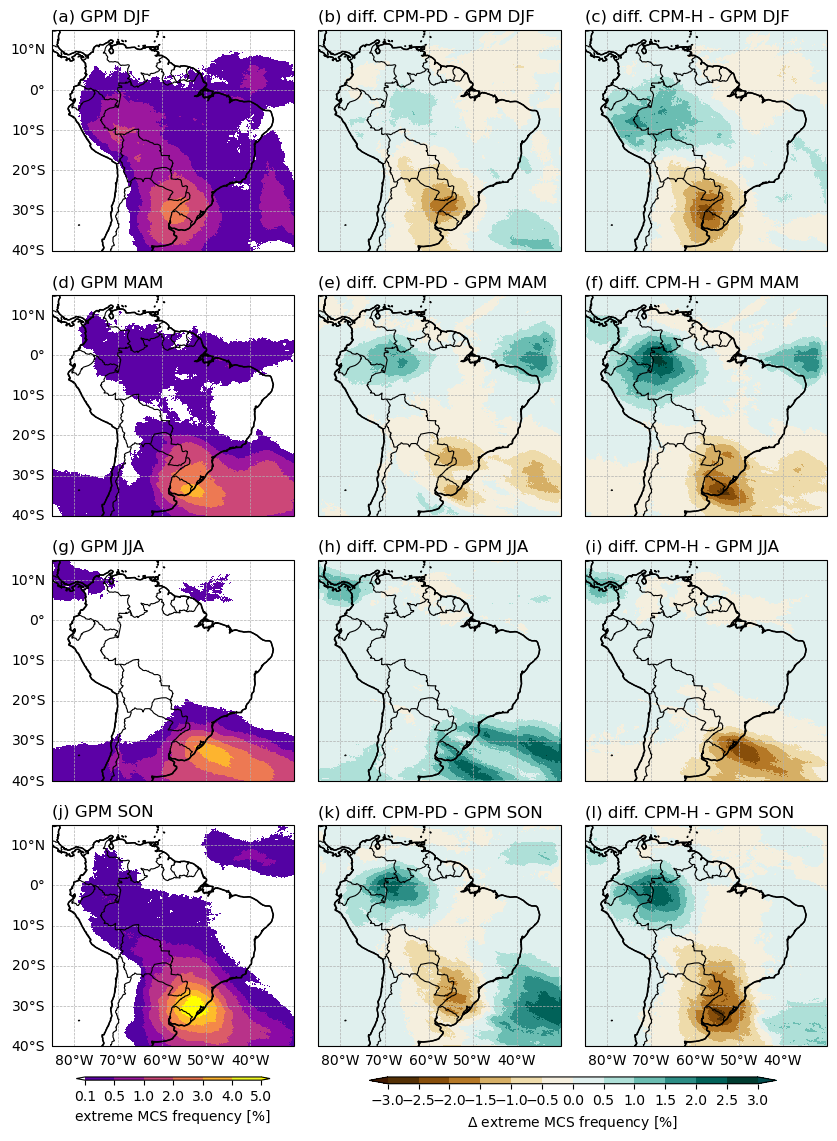

In [43]:
import matplotlib as mpl
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter


levels = [0.1, 0.5, 1, 2, 3, 4, 5]
levelsdiff = np.arange(-3, 3.1, 0.5)


proj = ccrs.PlateCarree()

cmap = mpl.cm.plasma.with_extremes(under='white', over='yellow')
#cmap = mpl.colors.ListedColormap(['white', '#a2cffe', '#658cbb', '#029386', '#75b84f', '#fac205', '#f97306', '#ef4026', '#8f1402'])
cmap_diff = mpl.cm.BrBG.with_extremes(under='#411900', over='#014d4e', bad=None)

resolution = '50m'
land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
borders = cfeature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', resolution)


fig, geo_axes = plt.subplots(figsize=(10, 16), nrows=4, ncols=3, subplot_kw=dict(projection=proj))

### DJF ###
###########
o_djf = obs_percent_djf.plot(levels=levels, ax=geo_axes[0, 0],cmap=cmap, add_colorbar=False)
geo_axes[0, 0].set_title(' ')
geo_axes[0, 0].coastlines()
geo_axes[0, 0].set_title('(a) GPM DJF', loc='left')
geo_axes[0, 0].add_feature(borders, edgecolor='k', facecolor='none', linewidth=0.8, zorder=3)
geo_axes[0, 0].add_feature(land, facecolor='none', edgecolor='k', zorder=3)
geo_axes[0, 0].set_aspect('auto', adjustable=None)
geo_axes[0, 0].set_xlim(-85, -30)
# Set up grid lines and labels
gl = geo_axes[0, 0].gridlines(crs=proj, draw_labels=True, linestyle='--', linewidth=0.5)
gl.right_labels = False
gl.top_labels = False
gl.bottom_labels = False
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()        
geo_axes[0, 0].xaxis.set_major_formatter(lon_formatter)
geo_axes[0, 0].yaxis.set_major_formatter(lat_formatter)

pd_o_djf.plot(levels=levelsdiff, ax=geo_axes[0, 1],cmap=cmap_diff, add_colorbar=False)
geo_axes[0, 1].set_title(' ')
geo_axes[0, 1].coastlines()
geo_axes[0, 1].set_title('(b) diff. CPM-PD - GPM DJF', loc='left')
geo_axes[0, 1].add_feature(borders, edgecolor='k', facecolor='none', linewidth=0.8, zorder=3)
geo_axes[0, 1].add_feature(land, facecolor='none', edgecolor='k', zorder=3)
geo_axes[0, 1].set_aspect('auto', adjustable=None)
geo_axes[0, 1].set_xlim(-85, -30)
# Set up grid lines and labels
gl = geo_axes[0, 1].gridlines(crs=proj, draw_labels=True, linestyle='--', linewidth=0.5)
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
gl.bottom_labels = False
lon_formatter = LongitudeFormatter(zero_direction_label=True)       
geo_axes[0, 1].xaxis.set_major_formatter(lon_formatter)


h_o_djf.plot(levels=levelsdiff, ax=geo_axes[0, 2], cmap=cmap_diff, vmin=-30, vmax=30, add_colorbar=False)
geo_axes[0, 2].set_title(' ')
geo_axes[0, 2].coastlines()
geo_axes[0, 2].set_title('(c) diff. CPM-H - GPM DJF', loc='left')
geo_axes[0, 2].add_feature(borders, edgecolor='k', facecolor='none', linewidth=0.8, zorder=3)
geo_axes[0, 2].add_feature(land, facecolor='none', edgecolor='k', zorder=3)
geo_axes[0, 2].set_aspect('auto', adjustable=None)
geo_axes[0, 2].set_xlim(-85, -30)
# Set up grid lines and labels
gl = geo_axes[0, 2].gridlines(crs=proj, draw_labels=True, linestyle='--', linewidth=0.5)
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
gl.bottom_labels = False
lon_formatter = LongitudeFormatter(zero_direction_label=True)       
geo_axes[0, 2].xaxis.set_major_formatter(lon_formatter)


### MAM ###
###########
o_mam = obs_percent_mam.plot(levels=levels, ax=geo_axes[1, 0],cmap=cmap, add_colorbar=False)
geo_axes[1, 0].set_title(' ')
geo_axes[1, 0].coastlines()
geo_axes[1, 0].set_title('(d) GPM MAM', loc='left')
geo_axes[1, 0].add_feature(borders, edgecolor='k', facecolor='none', linewidth=0.8, zorder=3)
geo_axes[1, 0].add_feature(land, facecolor='none', edgecolor='k', zorder=3)
geo_axes[1, 0].set_aspect('auto', adjustable=None)
geo_axes[1, 0].set_xlim(-85, -30)
# Set up grid lines and labels
gl = geo_axes[1, 0].gridlines(crs=proj, draw_labels=True, linestyle='--', linewidth=0.5)
gl.right_labels = False
gl.top_labels = False
gl.bottom_labels = False
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()        
geo_axes[1, 0].xaxis.set_major_formatter(lon_formatter)
geo_axes[1, 0].yaxis.set_major_formatter(lat_formatter)

pd_o_mam.plot(levels=levelsdiff, ax=geo_axes[1, 1],cmap=cmap_diff, add_colorbar=False)
geo_axes[1, 1].set_title(' ')
geo_axes[1, 1].coastlines()
geo_axes[1, 1].set_title('(e) diff. CPM-PD - GPM MAM', loc='left')
geo_axes[1, 1].add_feature(borders, edgecolor='k', facecolor='none', linewidth=0.8, zorder=3)
geo_axes[1, 1].add_feature(land, facecolor='none', edgecolor='k', zorder=3)
geo_axes[1, 1].set_aspect('auto', adjustable=None)
geo_axes[1, 1].set_xlim(-85, -30)
# Set up grid lines and labels
gl = geo_axes[1, 1].gridlines(crs=proj, draw_labels=True, linestyle='--', linewidth=0.5)
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
gl.bottom_labels = False
lon_formatter = LongitudeFormatter(zero_direction_label=True)       
geo_axes[1, 1].xaxis.set_major_formatter(lon_formatter)


h_o_mam.plot(levels=levelsdiff, ax=geo_axes[1, 2], cmap=cmap_diff, vmin=-30, vmax=30, add_colorbar=False)
geo_axes[1, 2].set_title(' ')
geo_axes[1, 2].coastlines()
geo_axes[1, 2].set_title('(f) diff. CPM-H - GPM MAM', loc='left')
geo_axes[1, 2].add_feature(borders, edgecolor='k', facecolor='none', linewidth=0.8, zorder=3)
geo_axes[1, 2].add_feature(land, facecolor='none', edgecolor='k', zorder=3)
geo_axes[1, 2].set_aspect('auto', adjustable=None)
geo_axes[1, 2].set_xlim(-85, -30)
# Set up grid lines and labels
gl = geo_axes[1, 2].gridlines(crs=proj, draw_labels=True, linestyle='--', linewidth=0.5)
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
gl.bottom_labels = False
lon_formatter = LongitudeFormatter(zero_direction_label=True)       
geo_axes[1, 2].xaxis.set_major_formatter(lon_formatter)


### JJA ###
###########
o_jja = obs_percent_jja.plot(levels=levels, ax=geo_axes[2, 0],cmap=cmap, add_colorbar=False)
geo_axes[2, 0].set_title(' ')
geo_axes[2, 0].coastlines()
geo_axes[2, 0].set_title('(g) GPM JJA', loc='left')
geo_axes[2, 0].add_feature(borders, edgecolor='k', facecolor='none', linewidth=0.8, zorder=3)
geo_axes[2, 0].add_feature(land, facecolor='none', edgecolor='k', zorder=3)
geo_axes[2, 0].set_aspect('auto', adjustable=None)
geo_axes[2, 0].set_xlim(-85, -30)
# Set up grid lines and labels
gl = geo_axes[2, 0].gridlines(crs=proj, draw_labels=True, linestyle='--', linewidth=0.5)
gl.right_labels = False
gl.top_labels = False
gl.bottom_labels = False
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()        
geo_axes[2, 0].xaxis.set_major_formatter(lon_formatter)
geo_axes[2, 0].yaxis.set_major_formatter(lat_formatter)

pd_o_jja.plot(levels=levelsdiff, ax=geo_axes[2, 1],cmap=cmap_diff, add_colorbar=False)
geo_axes[2, 1].set_title(' ')
geo_axes[2, 1].coastlines()
geo_axes[2, 1].set_title('(h) diff. CPM-PD - GPM JJA', loc='left')
geo_axes[2, 1].add_feature(borders, edgecolor='k', facecolor='none', linewidth=0.8, zorder=3)
geo_axes[2, 1].add_feature(land, facecolor='none', edgecolor='k', zorder=3)
geo_axes[2, 1].set_aspect('auto', adjustable=None)
geo_axes[2, 1].set_xlim(-85, -30)
# Set up grid lines and labels
gl = geo_axes[2, 1].gridlines(crs=proj, draw_labels=True, linestyle='--', linewidth=0.5)
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
gl.bottom_labels = False
lon_formatter = LongitudeFormatter(zero_direction_label=True)       
geo_axes[2, 1].xaxis.set_major_formatter(lon_formatter)


h_o_jja.plot(levels=levelsdiff, ax=geo_axes[2, 2], cmap=cmap_diff, vmin=-30, vmax=30, add_colorbar=False)
geo_axes[2, 2].set_title(' ')
geo_axes[2, 2].coastlines()
geo_axes[2, 2].set_title('(i) diff. CPM-H - GPM JJA', loc='left')
geo_axes[2, 2].add_feature(borders, edgecolor='k', facecolor='none', linewidth=0.8, zorder=3)
geo_axes[2, 2].add_feature(land, facecolor='none', edgecolor='k', zorder=3)
geo_axes[2, 2].set_aspect('auto', adjustable=None)
geo_axes[2, 2].set_xlim(-85, -30)
# Set up grid lines and labels
gl = geo_axes[2, 2].gridlines(crs=proj, draw_labels=True, linestyle='--', linewidth=0.5)
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
gl.bottom_labels = False
lon_formatter = LongitudeFormatter(zero_direction_label=True)       
geo_axes[2, 2].xaxis.set_major_formatter(lon_formatter)


### SON ###
###########
o_son = obs_percent_son.plot(levels=levels, ax=geo_axes[3, 0],cmap=cmap, add_colorbar=False)
geo_axes[3, 0].set_title(' ')
geo_axes[3, 0].coastlines()
geo_axes[3, 0].set_title('(j) GPM SON', loc='left')
geo_axes[3, 0].add_feature(borders, edgecolor='k', facecolor='none', linewidth=0.8, zorder=3)
geo_axes[3, 0].add_feature(land, facecolor='none', edgecolor='k', zorder=3)
geo_axes[3, 0].set_aspect('auto', adjustable=None)
geo_axes[3, 0].set_xlim(-85, -30)
# Set up grid lines and labels
gl = geo_axes[3, 0].gridlines(crs=proj, draw_labels=True, linestyle='--', linewidth=0.5)
gl.right_labels = False
gl.top_labels = False
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()        
geo_axes[3, 0].xaxis.set_major_formatter(lon_formatter)
geo_axes[3, 0].yaxis.set_major_formatter(lat_formatter)

pd_o_son.plot(levels=levelsdiff, ax=geo_axes[3, 1],cmap=cmap_diff, add_colorbar=False)
geo_axes[3, 1].set_title(' ')
geo_axes[3, 1].coastlines()
geo_axes[3, 1].set_title('(k) diff. CPM-PD - GPM SON', loc='left')
geo_axes[3, 1].add_feature(borders, edgecolor='k', facecolor='none', linewidth=0.8, zorder=3)
geo_axes[3, 1].add_feature(land, facecolor='none', edgecolor='k', zorder=3)
geo_axes[3, 1].set_aspect('auto', adjustable=None)
geo_axes[3, 1].set_xlim(-85, -30)
# Set up grid lines and labels
gl = geo_axes[3, 1].gridlines(crs=proj, draw_labels=True, linestyle='--', linewidth=0.5)
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
lon_formatter = LongitudeFormatter(zero_direction_label=True)       
geo_axes[3, 1].xaxis.set_major_formatter(lon_formatter)


diff_h_o_son = h_o_son.plot(levels=levelsdiff, ax=geo_axes[3, 2], cmap=cmap_diff, vmin=-30, vmax=30, add_colorbar=False)
geo_axes[3, 2].set_title(' ')
geo_axes[3, 2].coastlines()
geo_axes[3, 2].set_title('(l) diff. CPM-H - GPM SON', loc='left')
geo_axes[3, 2].add_feature(borders, edgecolor='k', facecolor='none', linewidth=0.8, zorder=3)
geo_axes[3, 2].add_feature(land, facecolor='none', edgecolor='k', zorder=3)
geo_axes[3, 2].set_aspect('auto', adjustable=None)
geo_axes[3, 2].set_xlim(-85, -30)
# Set up grid lines and labels
gl = geo_axes[3, 2].gridlines(crs=proj, draw_labels=True, linestyle='--', linewidth=0.5)
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
lon_formatter = LongitudeFormatter(zero_direction_label=True)       
geo_axes[3, 2].xaxis.set_major_formatter(lon_formatter)


### shared colourbars ###
#########################
fig.subplots_adjust(wspace=0.1, hspace=0.2)
cbar = fig.colorbar(o_djf, location='bottom', pad=0.025, ticks=levels, ax=[geo_axes[0, 0], geo_axes[1, 0], geo_axes[2, 0], geo_axes[3, 0]], shrink=0.8, extend='both', aspect=60)
cbar.set_label(label='extreme MCS frequency [%]')
#cbar.ax.tick_params(labelsize=18)

cbar_diff = fig.colorbar(diff_h_o_son, location='bottom', pad=0.025, ticks=levelsdiff, ax=[geo_axes[0, 1], geo_axes[0, 2], geo_axes[1, 1], geo_axes[1, 2], geo_axes[2, 1], geo_axes[2, 2], geo_axes[3, 1], geo_axes[3, 2]], shrink=0.8, extend='both', aspect=60)
cbar_diff.set_label(label=r'$\Delta$ '+'extreme MCS frequency [%]')
#cbar_diff.ax.tick_params(labelsize=18)
